In [2]:
from pycaret.regression import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss,mean_absolute_error
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# 한글 깨짐
import platform
if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': #리눅스 (구글 콜랩)
        #!wget "https://www.wfonts.com/download/data/2016/06/13/malgun-gothic/malgun.ttf"
        #!mv malgun.ttf /usr/share/fonts/truetype/
        #import matplotlib.font_manager as fm 
        #fm._rebuild() 
        plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [4]:
train_raw = pd.read_csv('train.csv',encoding = 'utf-8')
test_raw = pd.read_csv('test.csv',encoding = 'utf-8')
train = train_raw
test = test_raw

In [5]:
holiday = pd.read_csv('holiday.csv',encoding = 'utf-8')

In [6]:
#메뉴는 일단 제외
drops = ['조식메뉴', '중식메뉴', '석식메뉴']

train = train.drop(drops, axis=1)
test = test.drop(drops, axis=1)

In [221]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   중식계             1205 non-null   float64
 8   석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 84.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가

In [120]:
#train.describe
print(train.isnull().sum())
print(test.isnull().sum())

일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
중식계               0
석식계               0
dtype: int64
일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
dtype: int64


In [7]:
#날짜 전처리;
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train['year'] = train['일자'].dt.year
train['month'] = train['일자'].dt.month
train['week'] = train['일자'].dt.week
train['day'] = train['일자'].dt.day

test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['week'] = test['일자'].dt.week
test['day'] = test['일자'].dt.day

In [8]:
#holiday join
holiday['요일'] = holiday['요일'].str[0]
holiday.rename(columns ={
    '명칭':'명칭','날짜':'일자','요일':'요일'},inplace = True)
holiday.head(20)

,명칭,일자,요일
0,신정,20160101,금
1,설날,20160207,일
2,설날,20160208,월
3,설날,20160209,화
4,대체공휴일,20160210,수
5,삼일절,20160301,화
6,국회의원선거일,20160413,수
7,어린이날,20160505,목
8,석가탄신일,20160514,토
9,현충일,20160606,월


In [10]:
#pd.to_datetime input 인자 str
holiday['일자'] = pd.to_datetime(holiday['일자'].astype('str'))
holiday.head()
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   명칭      103 non-null    object        
 1   일자      103 non-null    datetime64[ns]
 2   요일      103 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 2.5+ KB


In [11]:
train.일자.head(30)

0    2016-02-01
1    2016-02-02
2    2016-02-03
3    2016-02-04
4    2016-02-05
5    2016-02-11
6    2016-02-12
7    2016-02-15
8    2016-02-16
9    2016-02-17
10   2016-02-18
11   2016-02-19
12   2016-02-22
13   2016-02-23
14   2016-02-24
15   2016-02-25
16   2016-02-26
17   2016-02-29
18   2016-03-02
19   2016-03-03
20   2016-03-04
21   2016-03-07
22   2016-03-08
23   2016-03-09
24   2016-03-10
25   2016-03-11
26   2016-03-14
27   2016-03-15
28   2016-03-16
29   2016-03-17
Name: 일자, dtype: datetime64[ns]

In [25]:
holiday_list = holiday['일자']
af_holiday = holiday_list.map(lambda x:x+dt.timedelta(days=1))
bf_holiday = holiday_list.map(lambda x:x-dt.timedelta(days=1))  
ab_holiday = [af_holiday,bf_holiday]
ab_holiday

[0     2016-01-02
 1     2016-02-08
 2     2016-02-09
 3     2016-02-10
 4     2016-02-11
 5     2016-03-02
 6     2016-04-14
 7     2016-05-06
 8     2016-05-15
 9     2016-06-07
 10    2016-08-16
 11    2016-09-15
 12    2016-09-16
 13    2016-09-17
 14    2016-10-04
 15    2016-10-10
 16    2016-12-26
 17    2017-01-02
 18    2017-01-28
 19    2017-01-29
 20    2017-01-30
 21    2017-01-31
 22    2017-03-02
 23    2017-05-04
 24    2017-05-06
 25    2017-05-10
 26    2017-06-07
 27    2017-08-16
 28    2017-10-03
 29    2017-10-04
 30    2017-10-04
 31    2017-10-05
 32    2017-10-06
 33    2017-10-07
 34    2017-10-10
 35    2017-12-26
 36    2018-01-02
 37    2018-02-16
 38    2018-02-17
 39    2018-02-18
 40    2018-03-02
 41    2018-05-06
 42    2018-05-08
 43    2018-05-23
 44    2018-06-07
 45    2018-06-14
 46    2018-08-16
 47    2018-09-24
 48    2018-09-25
 49    2018-09-26
 50    2018-09-27
 51    2018-10-04
 52    2018-10-10
 53    2018-12-26
 54    2019-01-02
 55    201

In [26]:
#왜 겹치는 날 있는데 1안나오니?
for i in range(0,len(train)-1):
    if train['일자'][i] in [af_holiday.item]:
        print(1)

In [24]:
a = train['일자'].apply(lambda x: 1 if x in [af_holiday.item,bf_holiday.item] else 0)
a.sum()

0

In [9]:
#요일 라벨 인코딩
weekday = {
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

#내부근무자수 생성
train['내부근무자수'] = train['본사정원수']-train['본사휴가자수']-train['본사출장자수']-train['현본사소속재택근무자수']
test['내부근무자수'] = test['본사정원수']-test['본사휴가자수']-test['본사출장자수']-test['현본사소속재택근무자수']

In [10]:
#석식계 요일 rank_labeling
weekday_rank4dinner = {
    1: 1,
    2: 2,
    3: 5,
    4: 3,
    5: 4,
}

train['요일(석식)'] = train['요일'].map(weekday_rank4dinner)
test['요일(석식)'] = test['요일'].map(weekday_rank4dinner)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   year            1205 non-null   int64         
 10  month           1205 non-null   int64         
 11  week            1205 non-null   int64         
 12  day             1205 non-null   int64         
 13  내부근무자수          1205 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(9)
memory usage:

<AxesSubplot:>

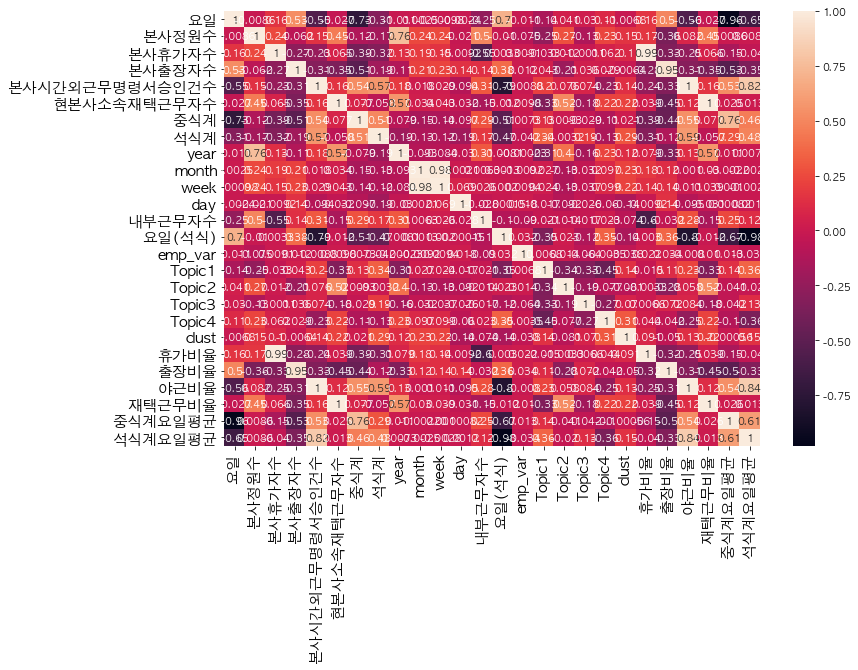

In [76]:
#상관관계 분석
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.heatmap(train.corr(), annot = True)
#중식계와 유의미한 변수 : 요일, 본사시간외근무명령서승인건수(야근),본사출장자수/석식계 ,본사휴가자수 
#석식계와 유의미한 변수 : 본사시간외근무명령서승인건수, 중식계, 본사휴가자수 

<AxesSubplot:>

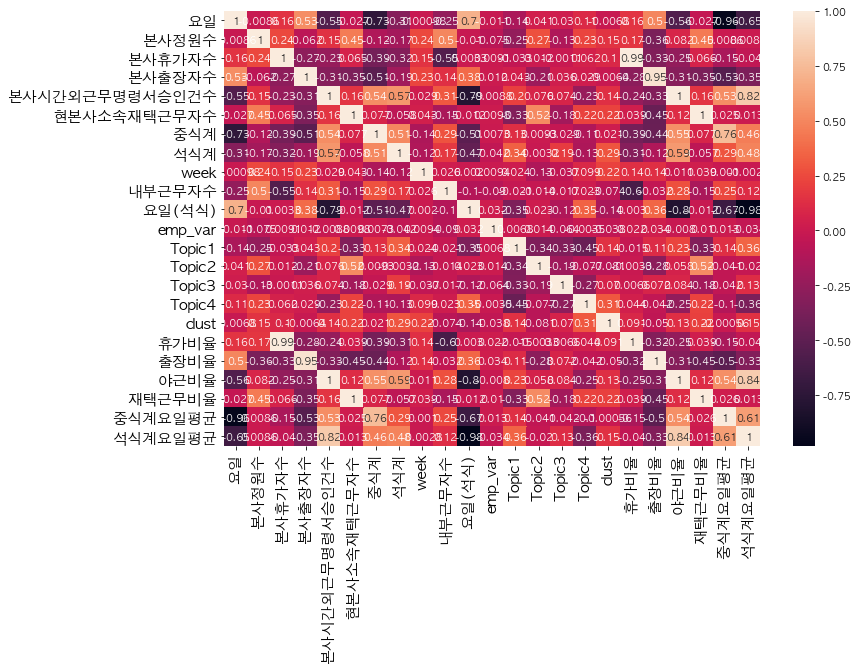

In [77]:
#요일 제외 유의미하지 않으니 year,month,day제외하고 heatmap
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.heatmap(train.drop(['year','month','day'],axis = 1).corr(),annot = True)

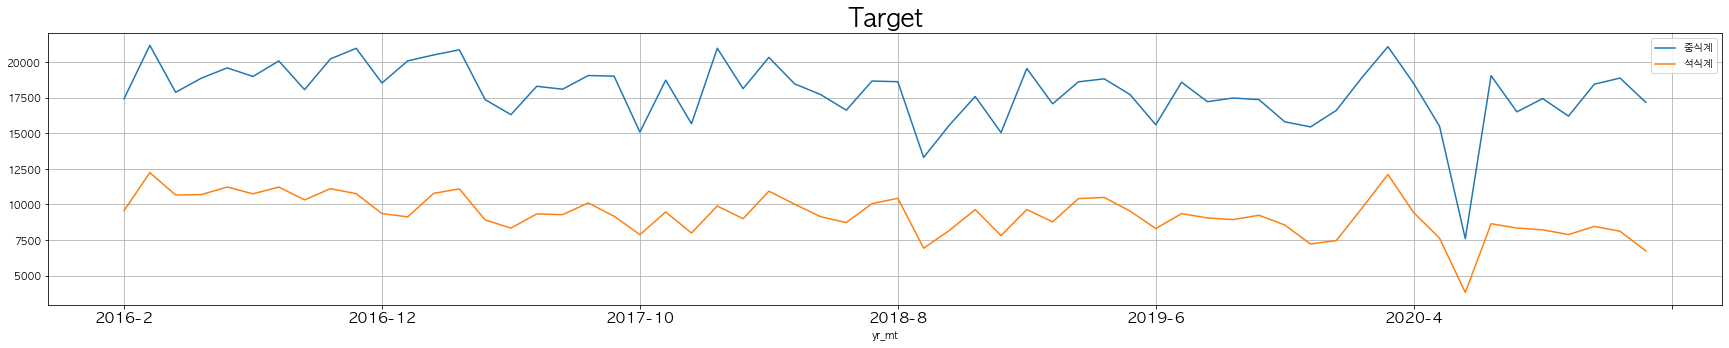

In [22]:
#일자에 따른 중석식계 시각화
mt_wk_hm = train.groupby(['year','month'])['중식계','석식계'].agg('sum').reset_index()
mt_wk_hm['yr_mt'] = mt_wk_hm['year'].astype(str)+ '-' + mt_wk_hm['month'].astype(str)
mt_wk_hm.plot(x = 'yr_mt', y = ['중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.title('Target', fontsize = 25)
plt.show()

- 시각화 결과 2020년 4월 이후 일정기간 중석식계 모두 감소가 있었다. 그 이유는 무엇일까?  
    가장 큰 예상 이유는 코로나이다. but, 코로나가 어떻게 본사에 영향을 주었는지는 추후에 판단이 필요하다
    - 예상1) 내부근무자수 감소(= 출장자 + 휴가자수 증가 or 재택근무자수 증가)
    - 예상2) 본사 정원수 감소

## 1.내부근무자수

<AxesSubplot:xlabel='내부근무자수', ylabel='Density'>

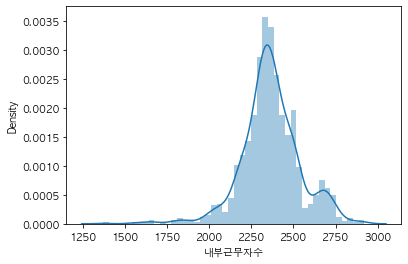

In [23]:
#내부근무자 수 분포
sns.distplot(train.내부근무자수)

<AxesSubplot:xlabel='year', ylabel='mean'>

<Figure size 864x576 with 0 Axes>

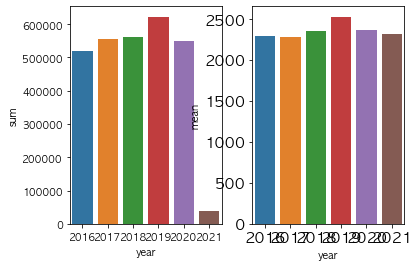

In [24]:
#년도별 내부근무자 수
yr_wk_cp = train.groupby('year')['내부근무자수'].agg(['sum','mean']).reset_index()
plt.figure(figsize = (12,8))
fig, ax = plt.subplots(1,2)
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.barplot(data = yr_wk_cp, x = 'year', y= 'sum',ax = ax[0])
sns.barplot(data = yr_wk_cp, x = 'year', y= 'mean',ax = ax[1])

년도별로 확인해보니 2019년보다 이후 조금 감소하였다.
보다 정확히 확인하기 위하여 월별로 확인해보자

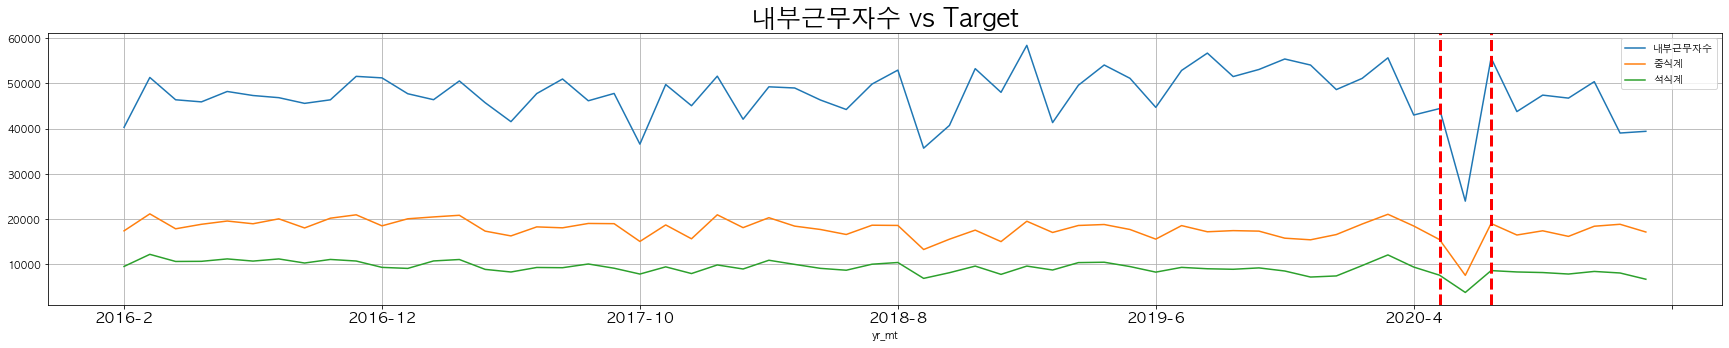

In [25]:
#년/월 내부근무자수에 따른 중석식계의 영향은?
mt_wk_cp = train.groupby(['year','month'])['내부근무자수','중식계','석식계'].agg('sum').reset_index()
mt_wk_cp['yr_mt'] = mt_wk_cp['year'].astype(str)+ '-' + mt_wk_cp['month'].astype(str)
mt_wk_cp.plot(x = 'yr_mt', y = ['내부근무자수', '중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.axvline(x=51, color='r', linestyle='--', linewidth=3)
plt.axvline(x=53, color='r', linestyle='--', linewidth=3)
plt.title('내부근무자수 vs Target', fontsize = 25)
plt.show()

- 시각화결과 같은 시기에 내부근무자수들 또한 감소하였다. 이것이 해당시기에 중석식계가 감소한 이유로 추측된다.
- 그렇다면 내부근무자수가 감소한 이유는?  
    예상1)재택근무자수 증가  
    예상2)출장자수 증가  
    예상3)휴가자수 증가  

### 1-1-1.재택근무자수
재택근무자수는 2020년 3월 이후에 존재한다 > 코로나 영향일 가능성 큼  

<AxesSubplot:xlabel='현본사소속재택근무자수', ylabel='Density'>

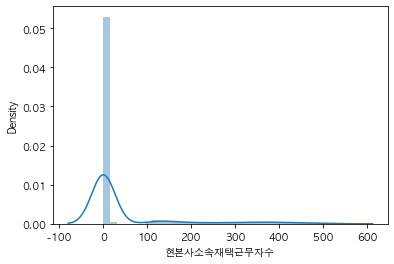

In [26]:
sns.distplot(train.현본사소속재택근무자수)
#0 > 재택근무하는 인원이 없었음

<AxesSubplot:xlabel='year', ylabel='현본사소속재택근무자수'>

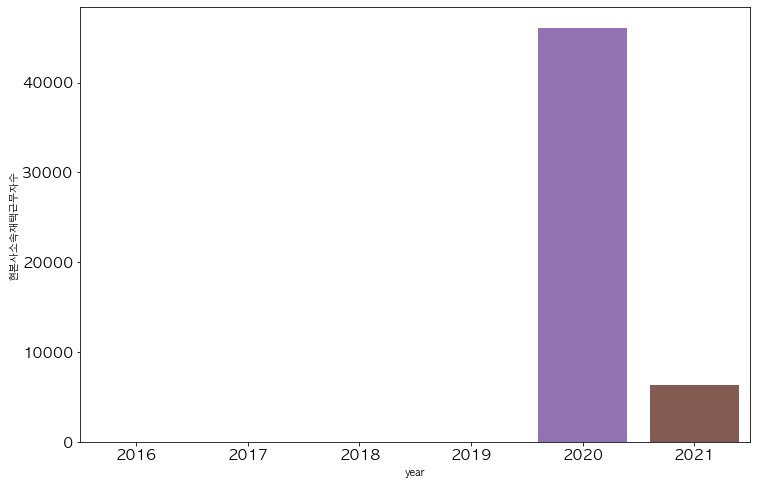

In [27]:
#년도별로 재택근무자수 확인 > 2020년 이전에는 재택근무자수 없음.
yr_wk_hm = train.groupby('year')['현본사소속재택근무자수'].agg('sum').reset_index()
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.barplot(data = yr_wk_hm, x = 'year', y= '현본사소속재택근무자수')

<AxesSubplot:xlabel='일자', ylabel='현본사소속재택근무자수'>

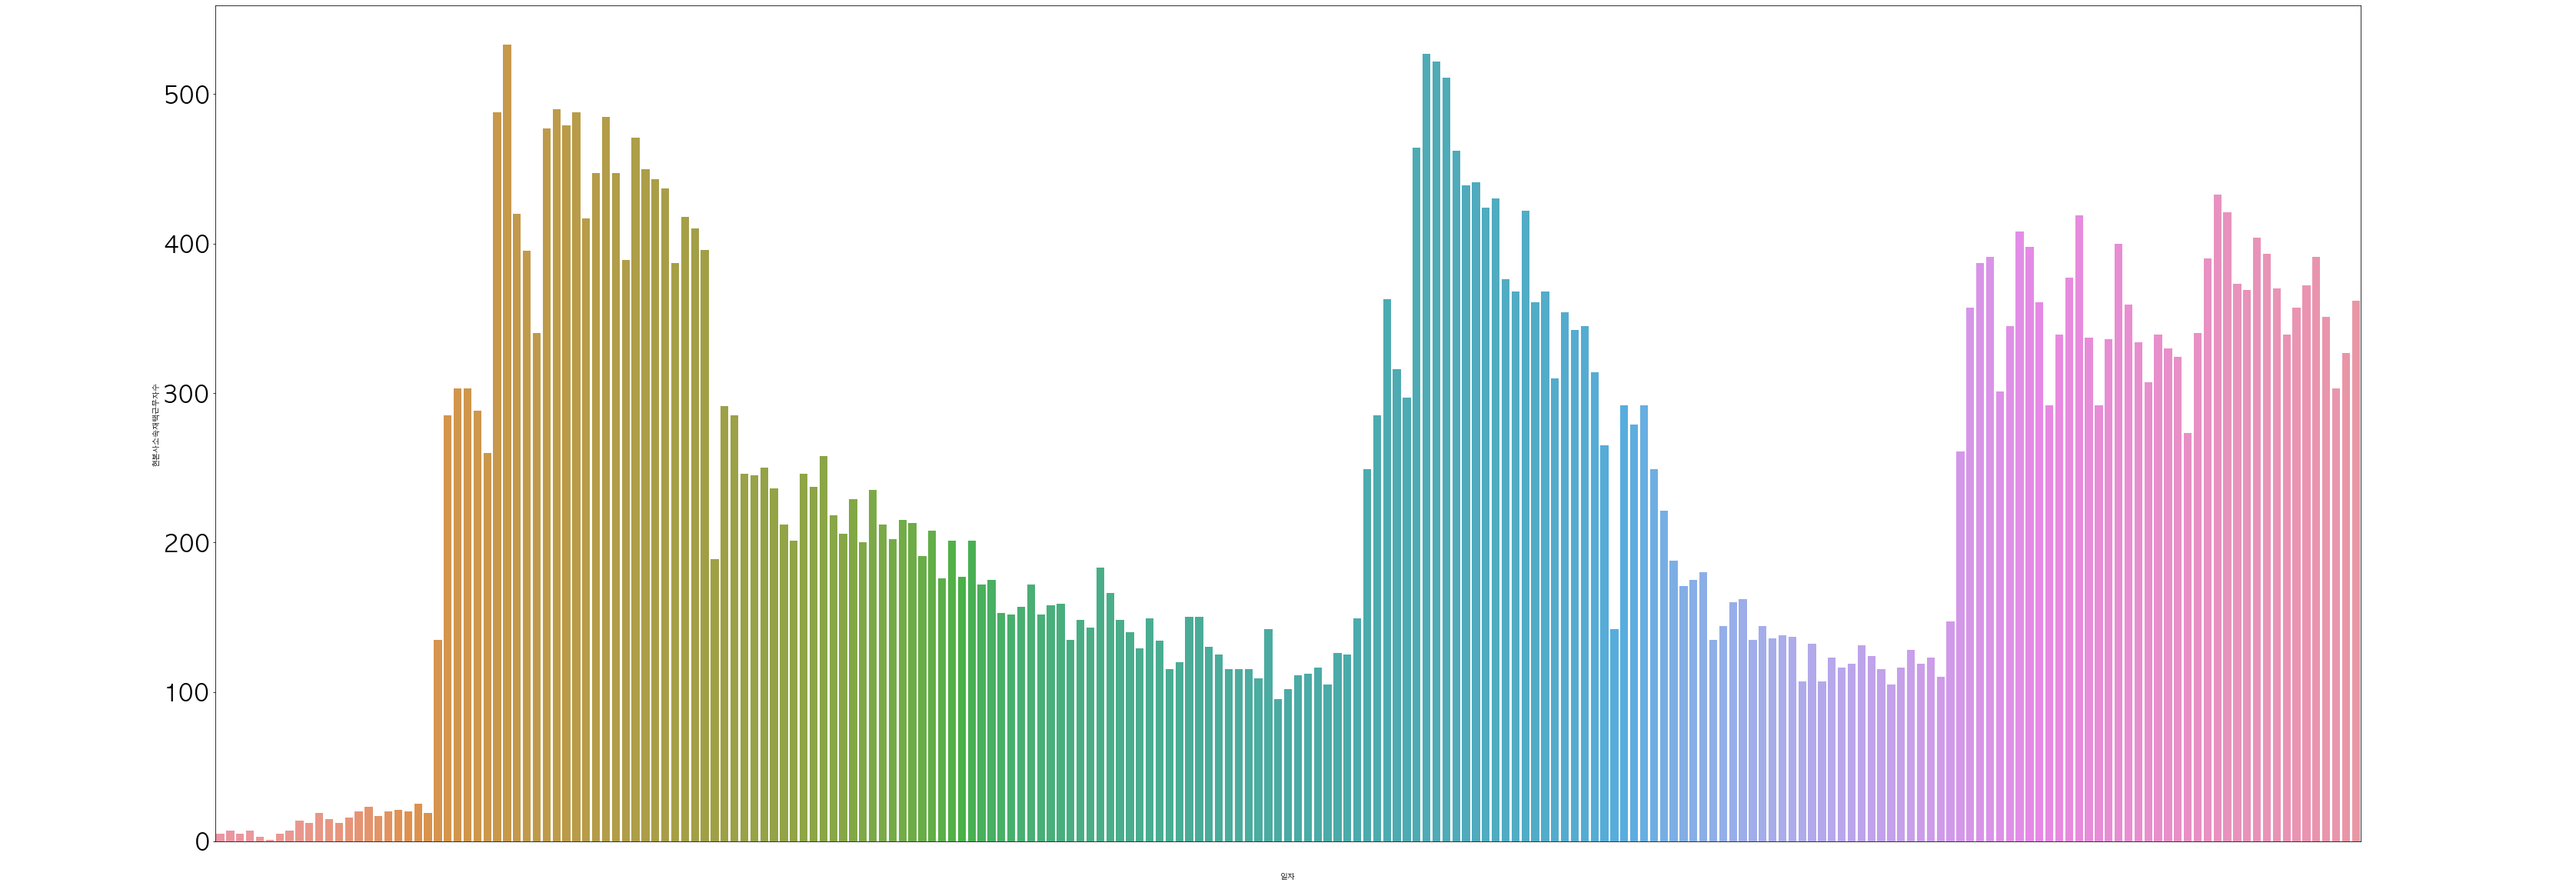

In [28]:
#그렇다면 일자별로 재택근무자수는?
wk_home = train[train['현본사소속재택근무자수']>0][['일자','현본사소속재택근무자수']]
plt.rcParams['figure.figsize'] = [50, 20]
plt.rc('xtick', labelsize=30,color = 'white') # fontsize of the tick labels
#plt.xticks(rotation=90)
plt.rc('ytick', labelsize=30) # fontsize of the tick labels
sns.barplot(data = wk_home,x = '일자', y = '현본사소속재택근무자수')

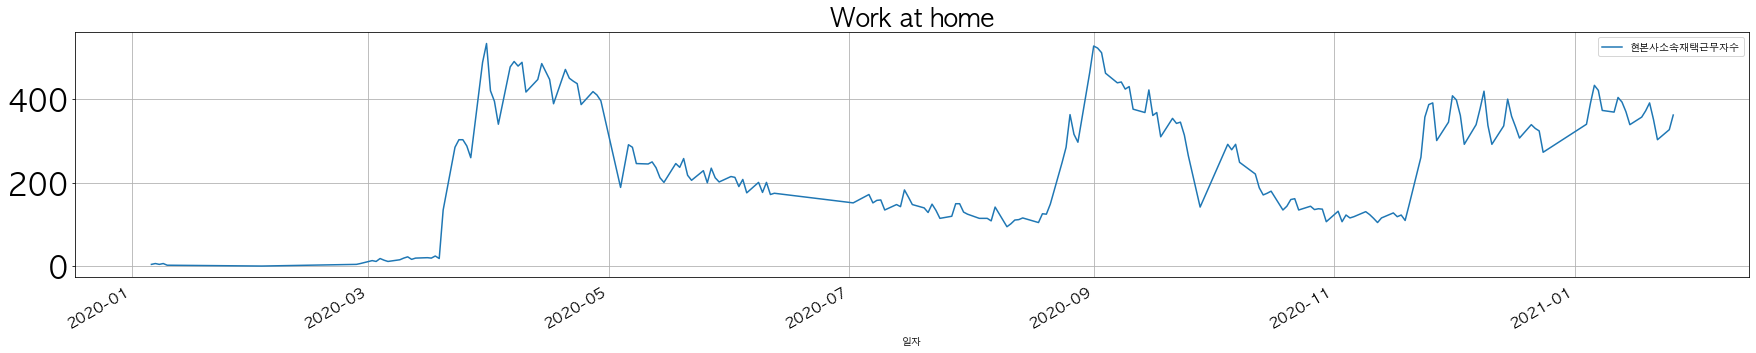

In [29]:
wk_home = train[train['현본사소속재택근무자수']>0][['일자','현본사소속재택근무자수']]
wk_home.plot(x = '일자', y = '현본사소속재택근무자수', figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.title('Work at home', fontsize = 25)
plt.show()

    year  month  현본사소속재택근무자수      중식계    yr_mt
47  2020      1         27.0  16606.0   2020-1
48  2020      2         13.0  18924.0   2020-2
49  2020      3       2848.0  21078.0   2020-3
50  2020      4       8686.0  18493.0   2020-4
51  2020      5       4398.0  15496.0   2020-5
52  2020      6       1929.0   7600.0   2020-6
53  2020      7       3368.0  19040.0   2020-7
54  2020      8       3611.0  16502.0   2020-8
55  2020      9       7723.0  17433.0   2020-9
56  2020     10       3445.0  16201.0  2020-10
57  2020     11       3857.0  18440.0  2020-11
58  2020     12       6225.0  18873.0  2020-12
59  2021      1       6295.0  17165.0   2021-1


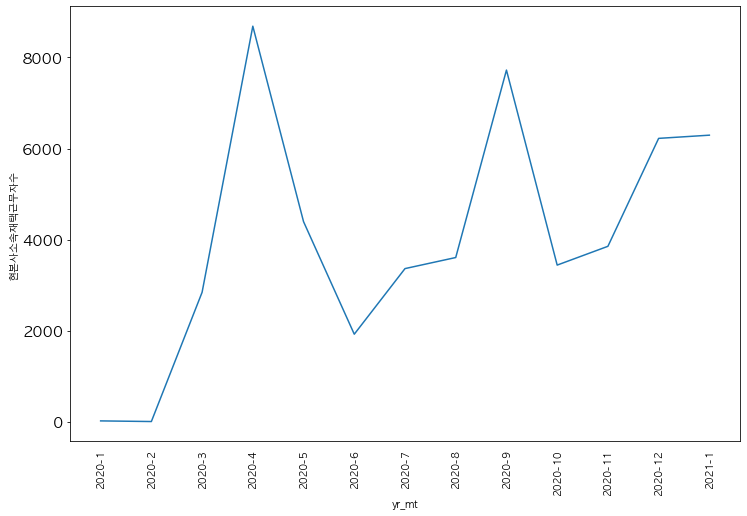

In [30]:
#월별로 묶어서 재택근무자수 보기
mt_wk_hm = train.groupby(['year','month'])['현본사소속재택근무자수','중식계'].agg('sum').reset_index()
mt_wk_hm['yr_mt'] = mt_wk_hm['year'].astype(str)+ '-' + mt_wk_hm['month'].astype(str)
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 10, rotation =90)
plt.yticks(color = "black", fontsize = 15)
sns.lineplot(data = mt_wk_hm[mt_wk_hm['현본사소속재택근무자수']>0], x = 'yr_mt',y= '현본사소속재택근무자수')
print(mt_wk_hm[mt_wk_hm['현본사소속재택근무자수']>0])

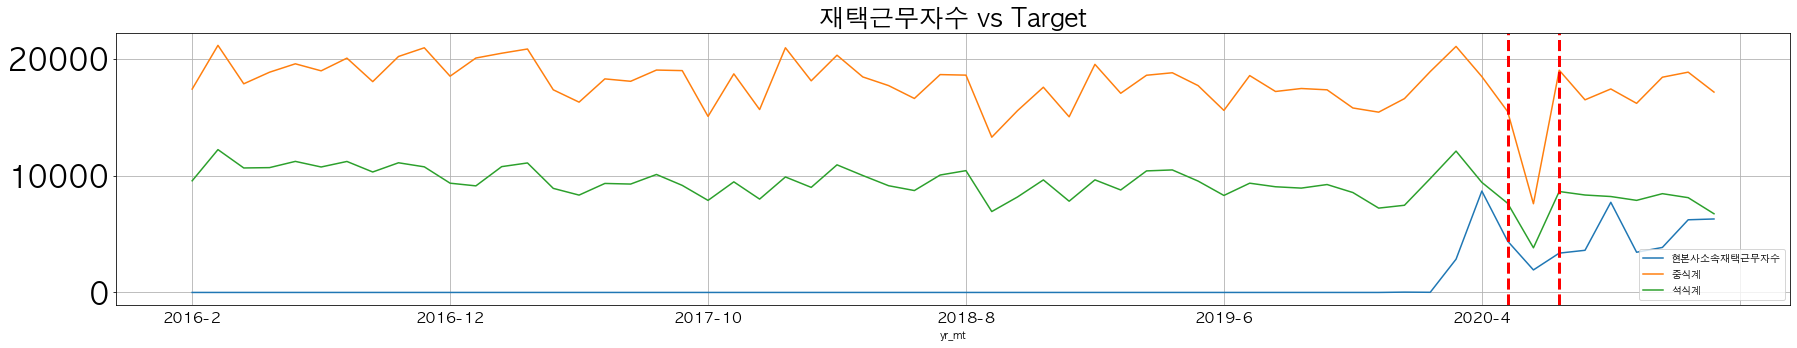

In [31]:
#재택근무자수에 따른 중석식계의 영향은?
mt_wk_hm = train.groupby(['year','month'])['현본사소속재택근무자수','중식계','석식계'].agg('sum').reset_index()
mt_wk_hm['yr_mt'] = mt_wk_hm['year'].astype(str)+ '-' + mt_wk_hm['month'].astype(str)
mt_wk_hm.plot(x = 'yr_mt', y = ['현본사소속재택근무자수', '중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.axvline(x=51, color='r', linestyle='--', linewidth=3)
plt.axvline(x=53, color='r', linestyle='--', linewidth=3)
plt.title('재택근무자수 vs Target', fontsize = 25)
plt.show()

-시각화 결과에 따르면 중석식계가 감소한 시기에 재택근무자수도 감소하였으니 이는 원인이 아니라고 예상된다

### 1-1-2.출장자 수

<AxesSubplot:xlabel='본사출장자수', ylabel='Density'>

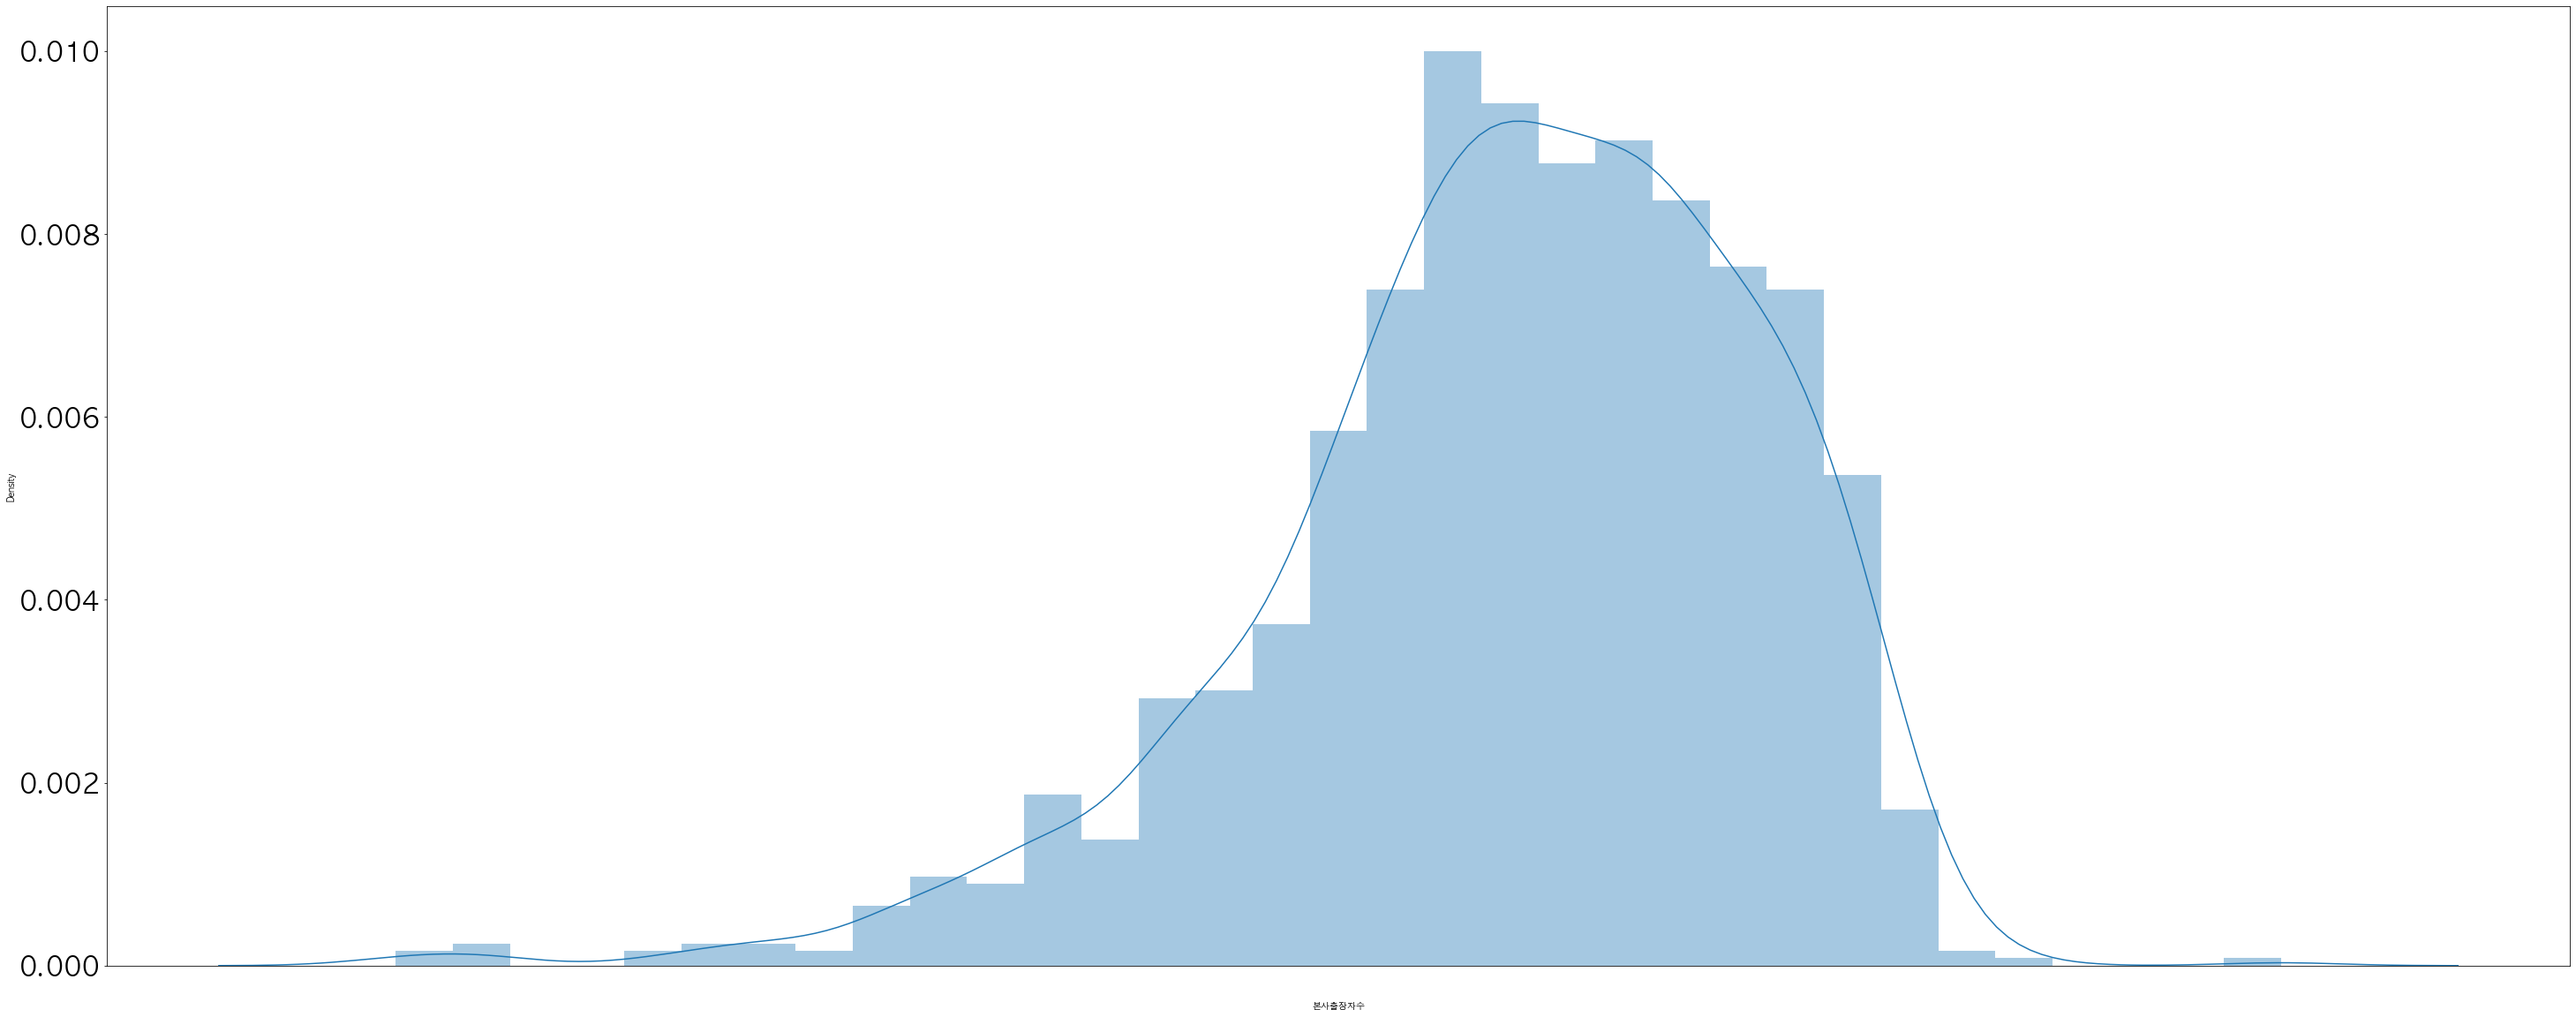

In [32]:
#출장자 수 분포
sns.distplot(train.본사출장자수)

<AxesSubplot:xlabel='year', ylabel='mean'>

<Figure size 864x576 with 0 Axes>

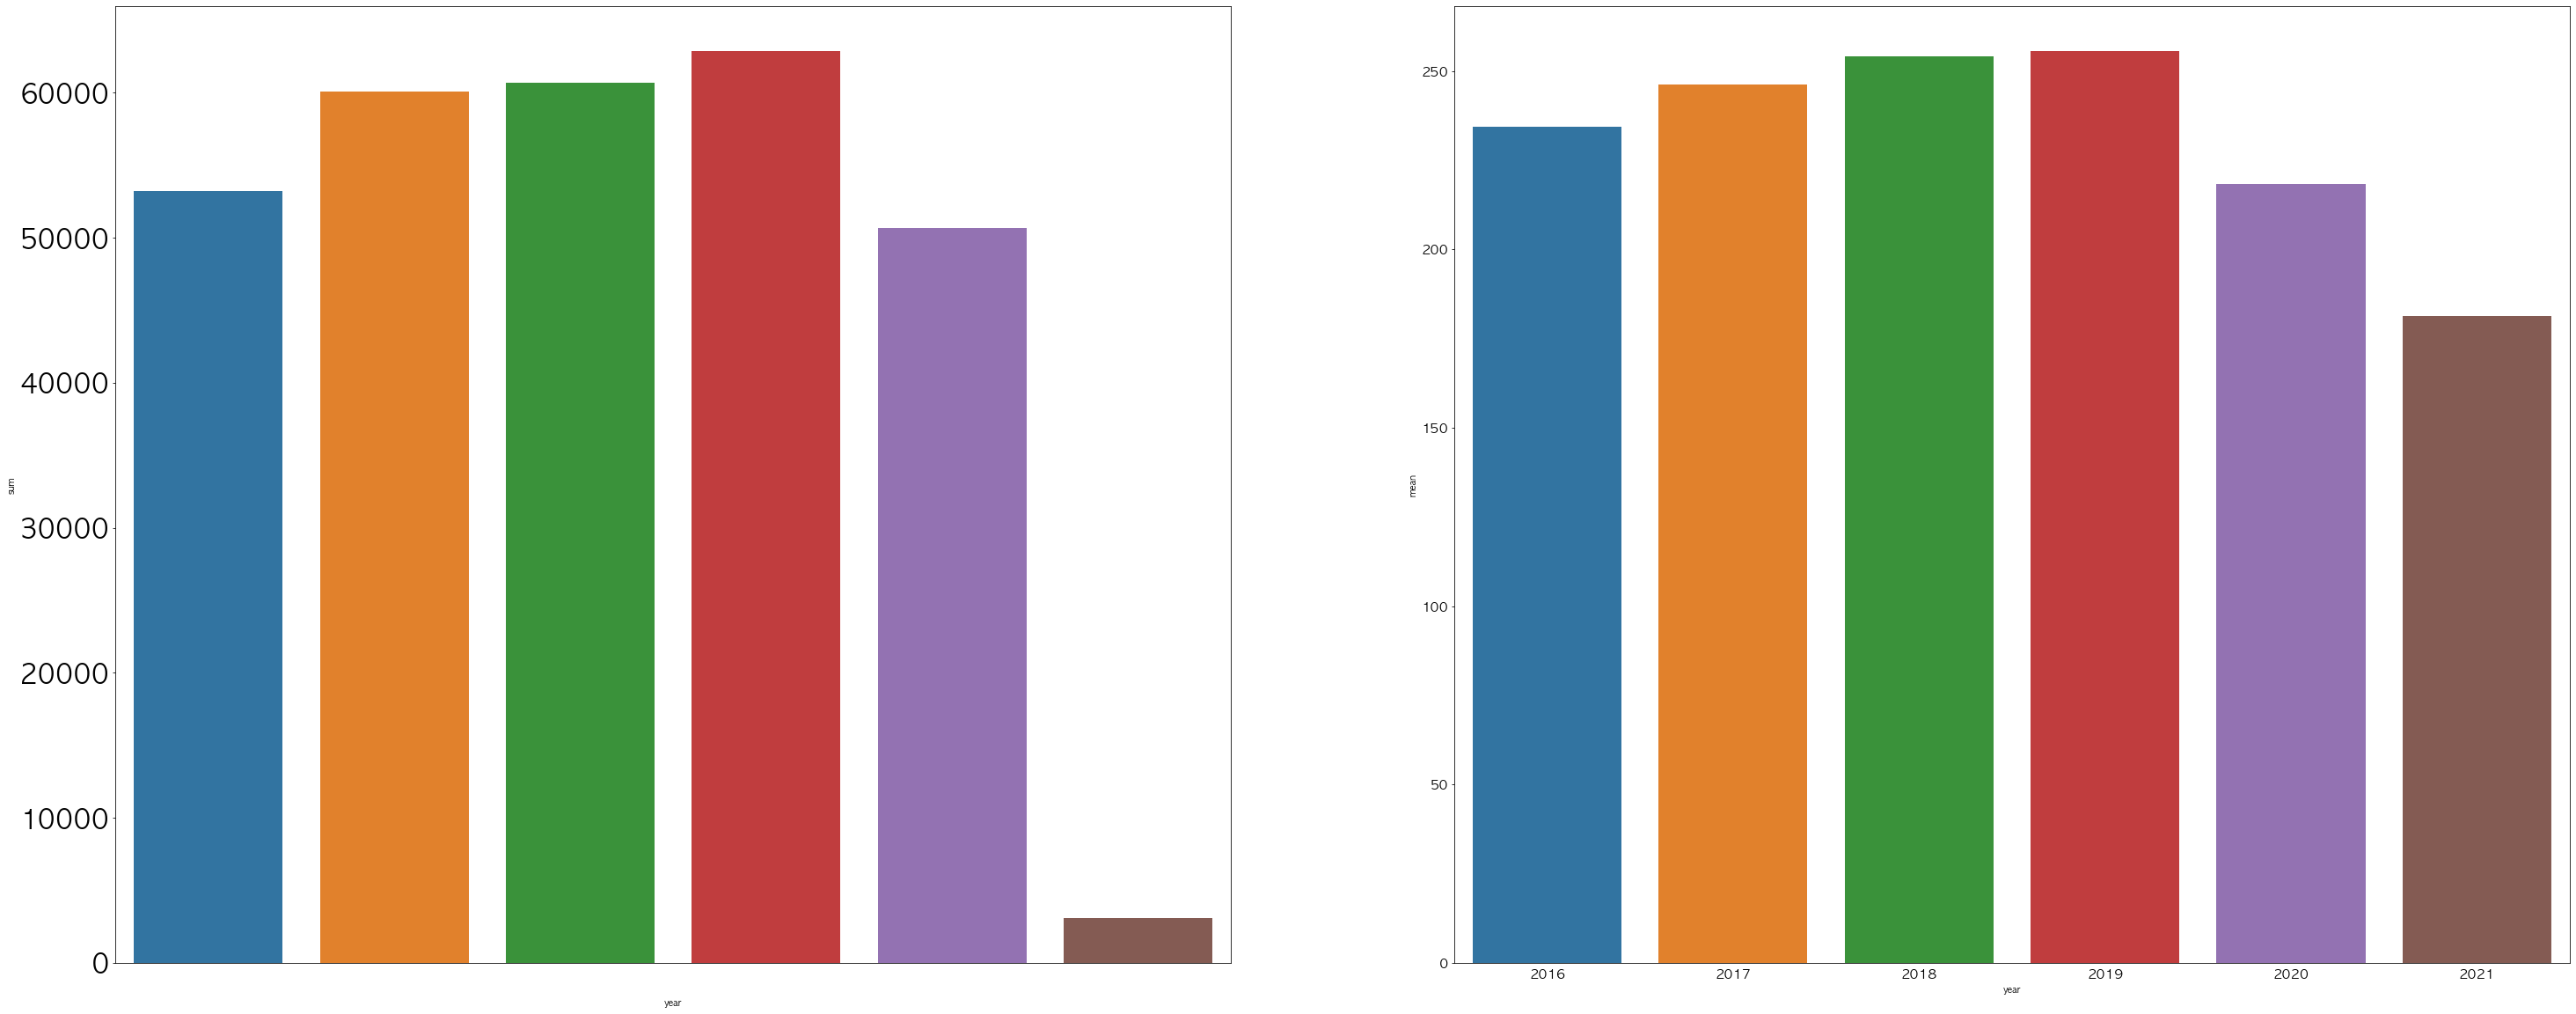

In [33]:
#년도별 본사출장자 수
yr_wk_bt = train.groupby('year')['본사출장자수'].agg(['sum','mean']).reset_index()
plt.figure(figsize = (12,8))
fig, ax = plt.subplots(1,2)
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.barplot(data = yr_wk_bt, x = 'year', y= 'sum',ax = ax[0])
sns.barplot(data = yr_wk_bt, x = 'year', y= 'mean',ax = ax[1])

시각화결과 앞의 재택근무자수보다 19년도 이후 감소세가 존재하는 것으로 확인된다. 월별로 확인해보자

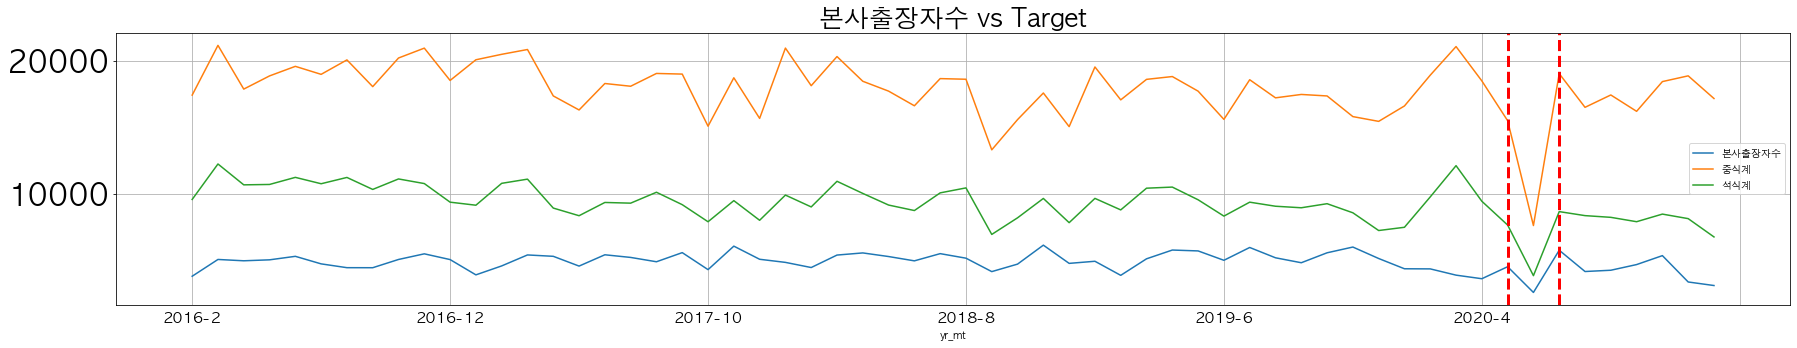

In [34]:
#년/월 본사출장자수에 따른 중석식계의 영향은?
mt_wk_bt = train.groupby(['year','month'])['본사출장자수','중식계','석식계'].agg('sum').reset_index()
mt_wk_bt['yr_mt'] = mt_wk_bt['year'].astype(str)+ '-' + mt_wk_bt['month'].astype(str)
mt_wk_bt.plot(x = 'yr_mt', y = ['본사출장자수', '중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.axvline(x=51, color='r', linestyle='--', linewidth=3)
plt.axvline(x=53, color='r', linestyle='--', linewidth=3)
plt.title('본사출장자수 vs Target', fontsize = 25)
plt.show()

시각화 결과 재택근무자수와 마찬가지로 해당시기에 본사출장자수 또한 감소하였다.  
따라서 본사출장자수 또한 해당시기에 중석식계 감소에 직접적인 영향을 주는 변수는 아니라고 판단된다.  
!본사출장자수가 줄어든 원인도 확인이 필요하다

## 1-1-3.본사휴가자수

<AxesSubplot:xlabel='본사휴가자수', ylabel='Density'>

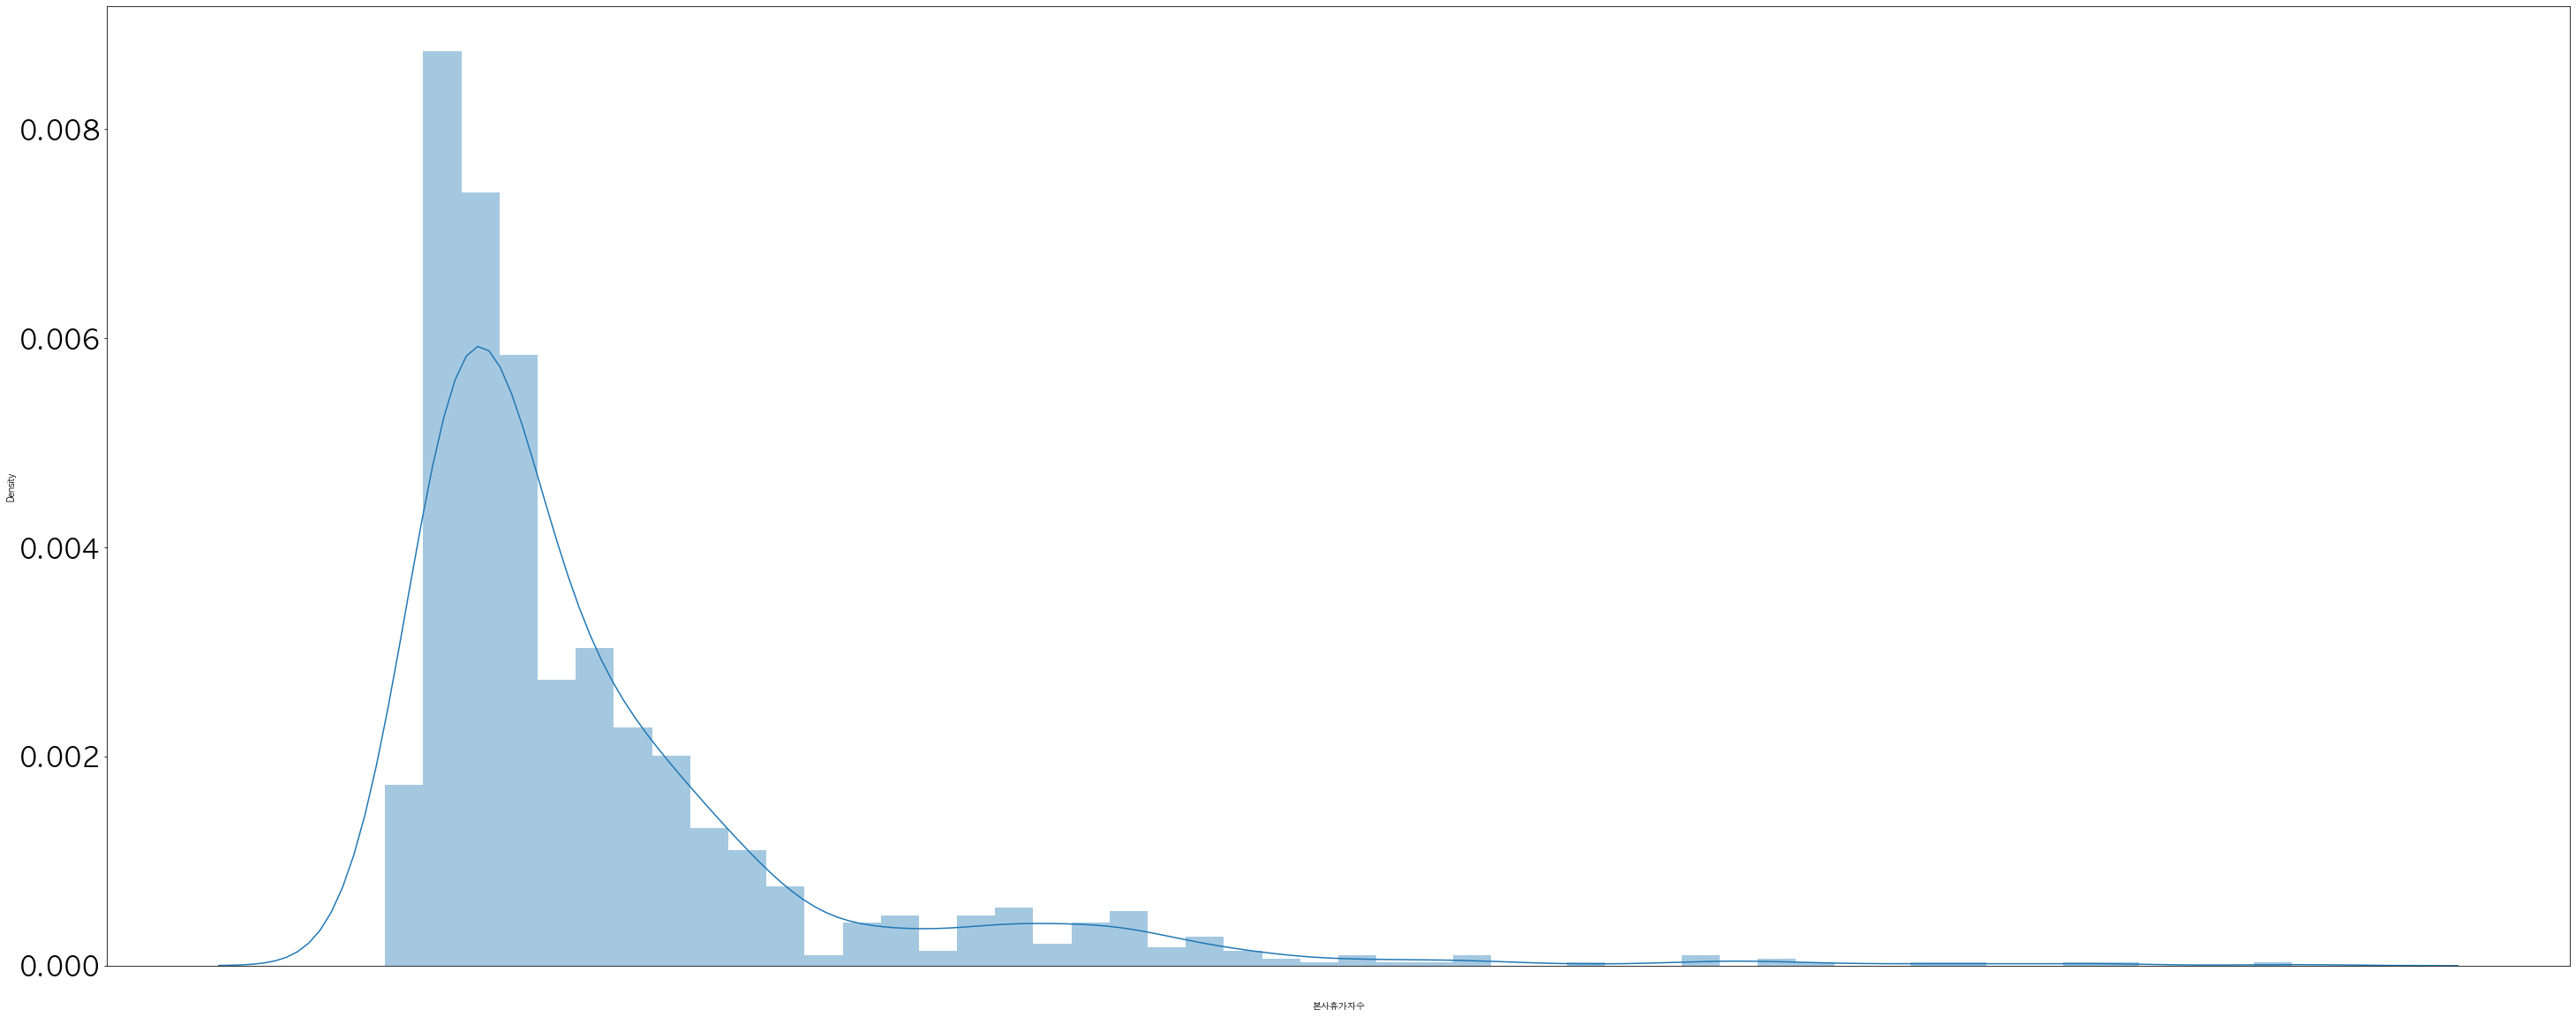

In [35]:
#휴가자 수 분포
sns.distplot(train.본사휴가자수)

휴가자 수는 앞의 변수들과 다르게 왼쪽으로 치우친 분포를 보인다

<AxesSubplot:xlabel='year', ylabel='mean'>

<Figure size 864x576 with 0 Axes>

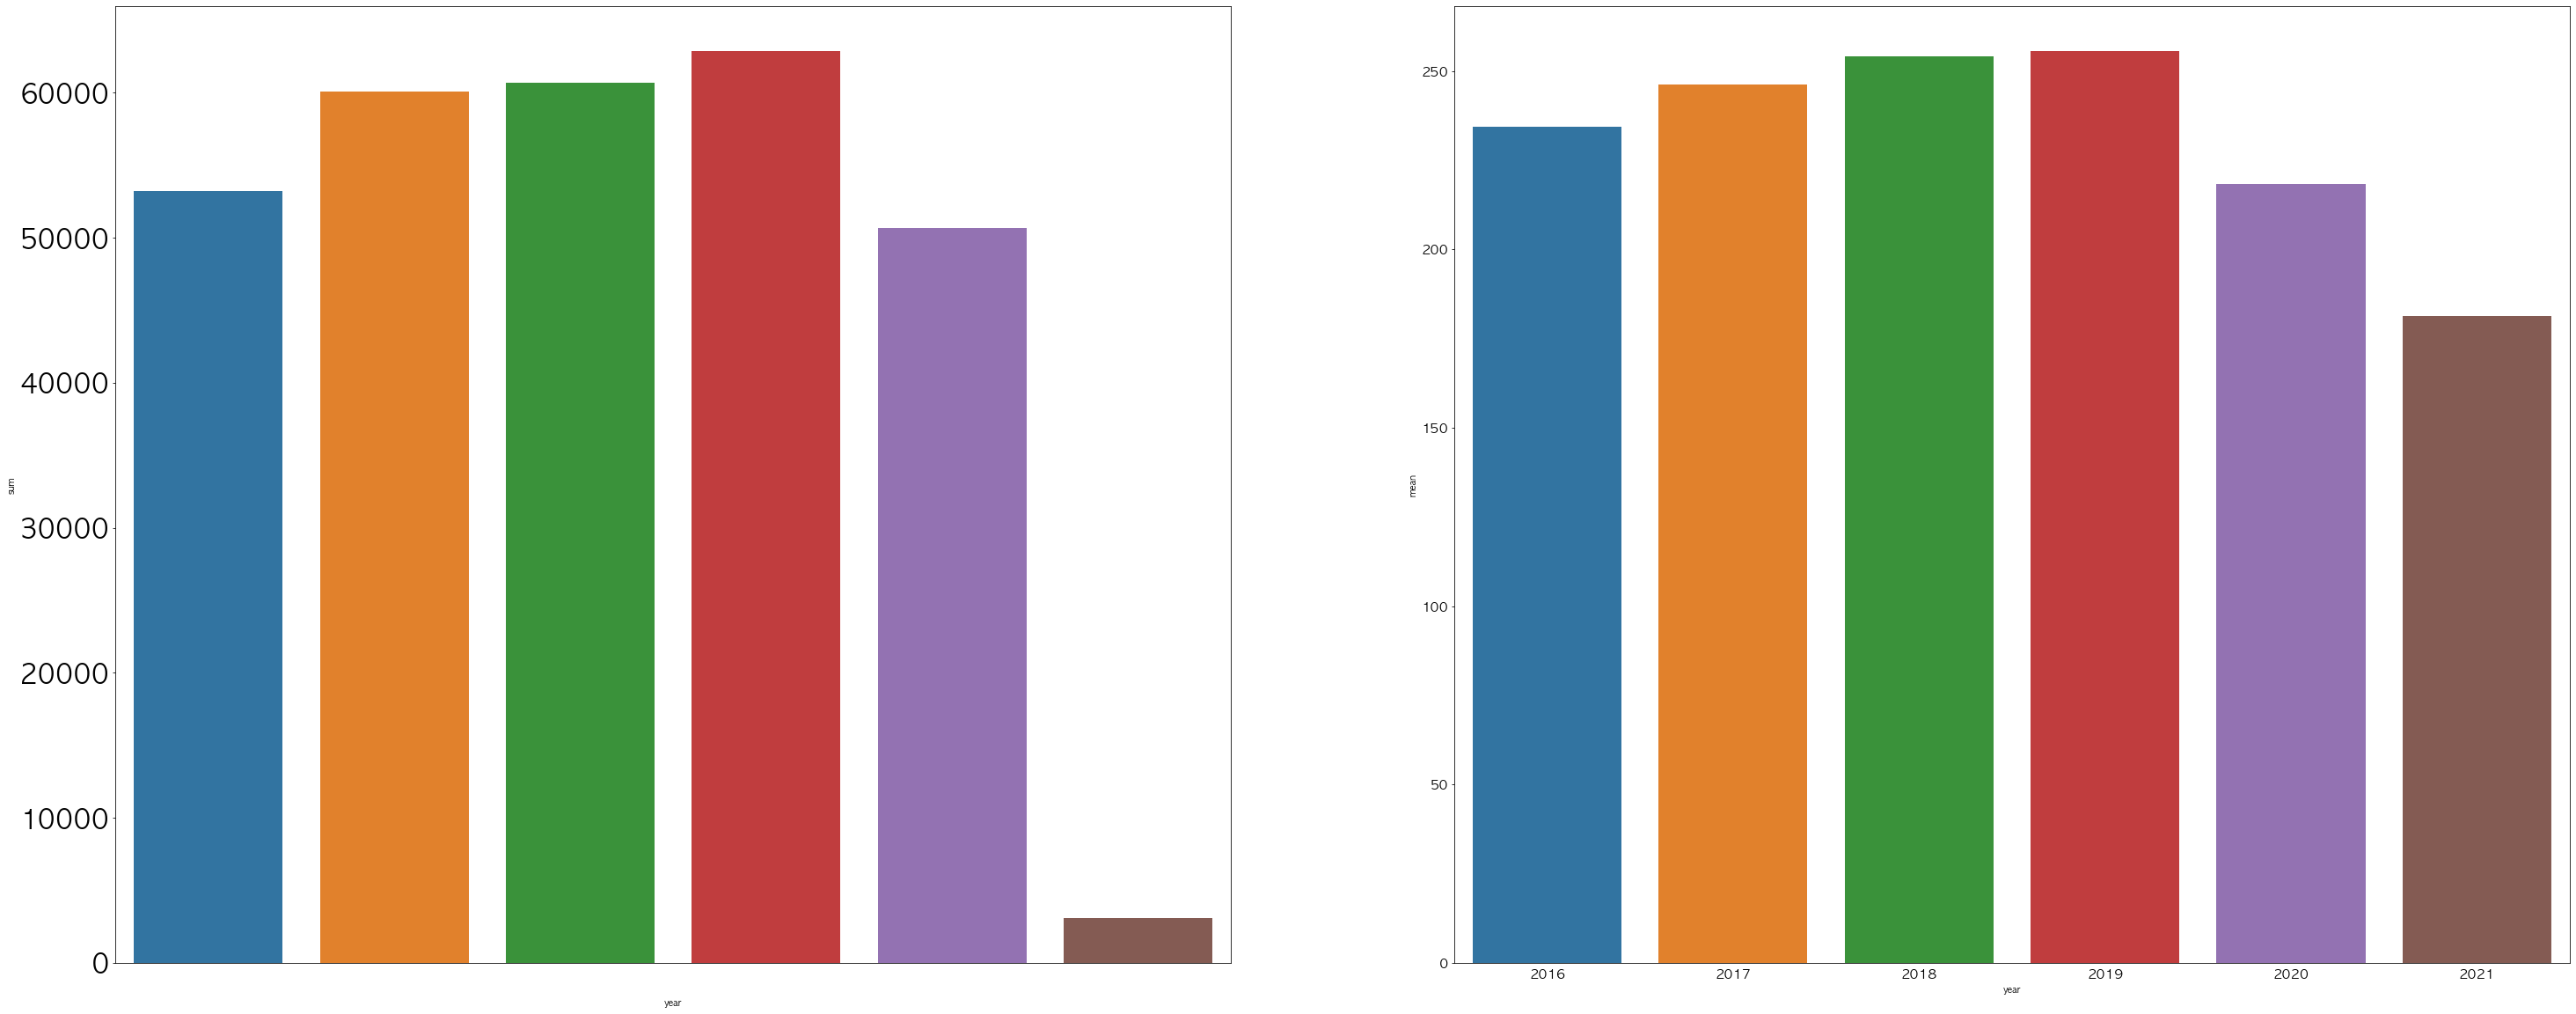

In [36]:
#년도별 본사휴가자 수
yr_wk_vc = train.groupby('year')['본사출장자수'].agg(['sum','mean']).reset_index()
plt.figure(figsize = (12,8))
fig, ax = plt.subplots(1,2)
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.barplot(data = yr_wk_vc, x = 'year', y= 'sum',ax = ax[0])
sns.barplot(data = yr_wk_vc, x = 'year', y= 'mean',ax = ax[1])

시각화 결과 휴가자 수 또한 19년도 이후 감소세가 있는 것으로 확인된다.

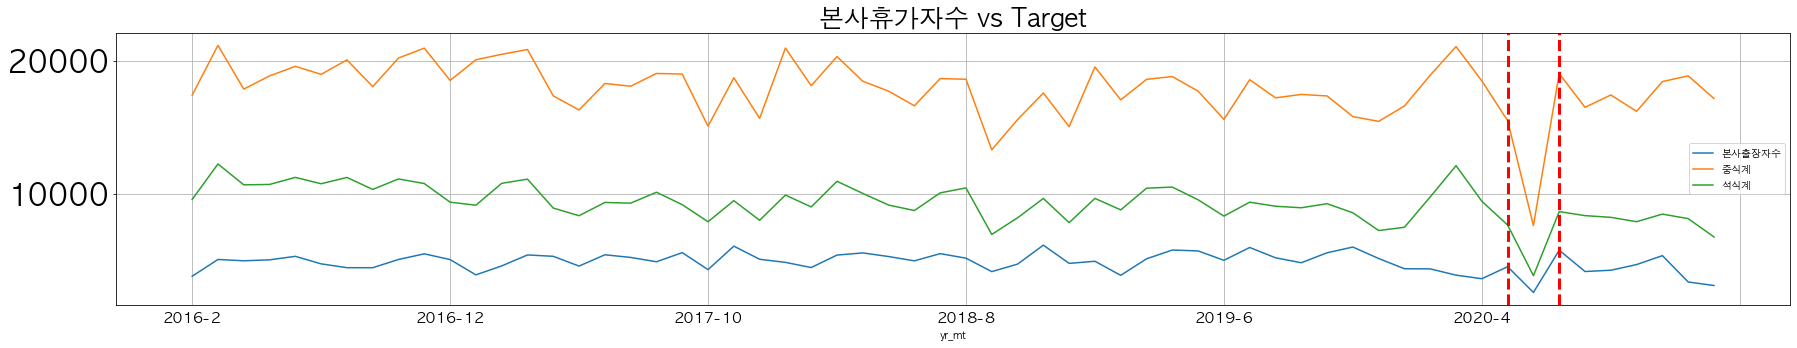

In [37]:
#년/월 본사휴가자수에 따른 중석식계의 영향은?
mt_wk_vc = train.groupby(['year','month'])['본사출장자수','중식계','석식계'].agg('sum').reset_index()
mt_wk_vc['yr_mt'] = mt_wk_vc['year'].astype(str)+ '-' + mt_wk_vc['month'].astype(str)
mt_wk_vc.plot(x = 'yr_mt', y = ['본사출장자수', '중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.axvline(x=51, color='r', linestyle='--', linewidth=3)
plt.axvline(x=53, color='r', linestyle='--', linewidth=3)
plt.title('본사휴가자수 vs Target', fontsize = 25)
plt.show()

본사 휴가자수도 같은 시기에 감소하고 있으므로 이는 원인이 아니다.  
또한 휴가자수의 감소 원인이 추후에 파악이 필요하다

## 2.본사 정원수

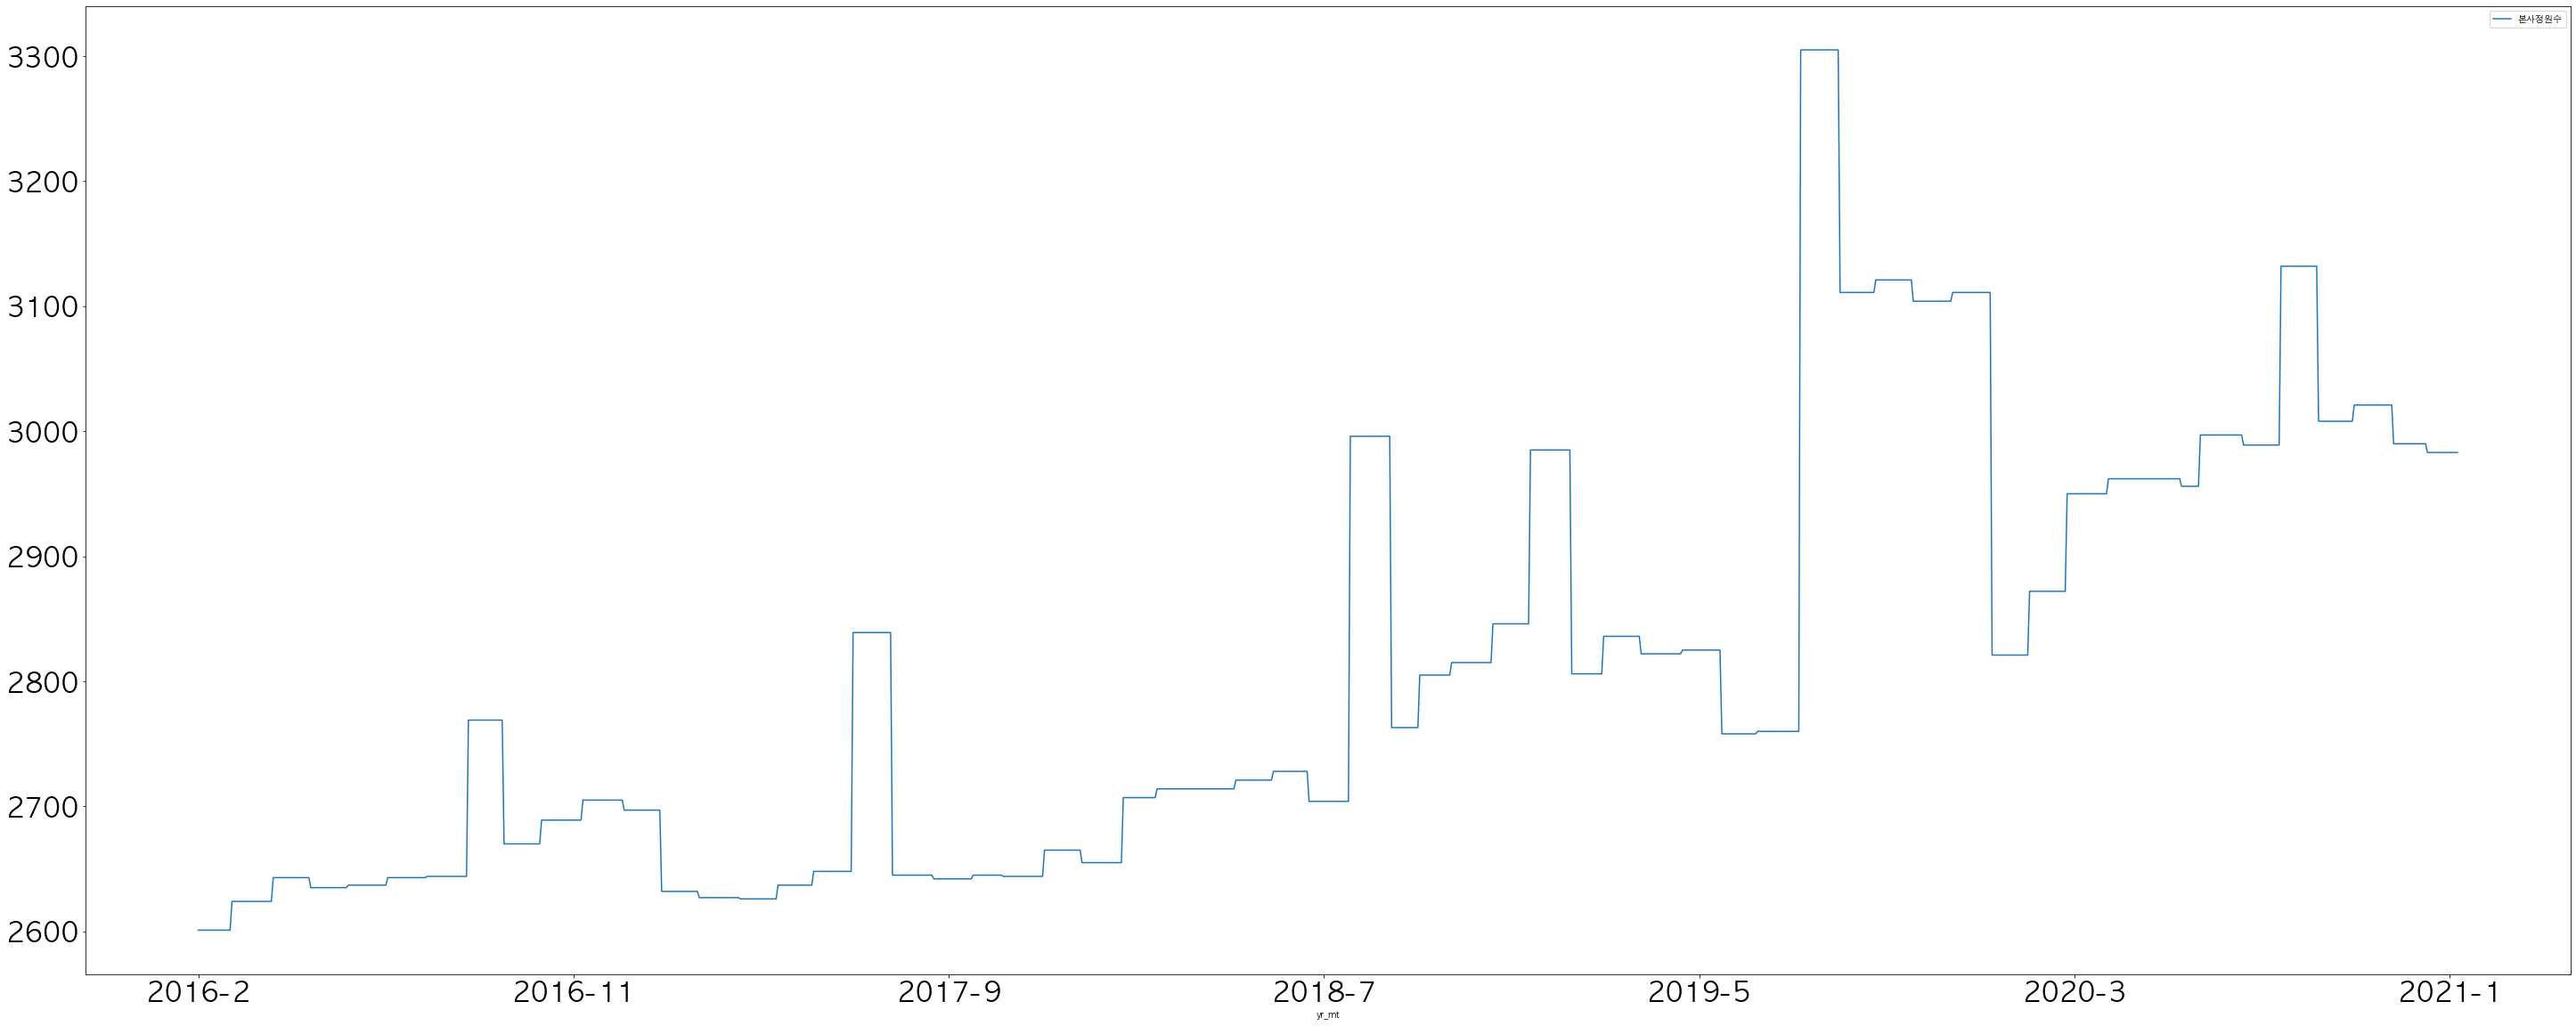

In [38]:
#본사정원수 시각화
train['yr_mt'] = train['year'].astype(str)+ '-' + train['month'].astype(str)
plt.rc('xtick', labelsize=30,color = 'black')
train.plot(x = 'yr_mt', y = '본사정원수')
plt.show()

시간이 지남에 따라 꾸준히 증가하고 있지만 중간중간 정원이 감소하는 이유는 무엇일까?  

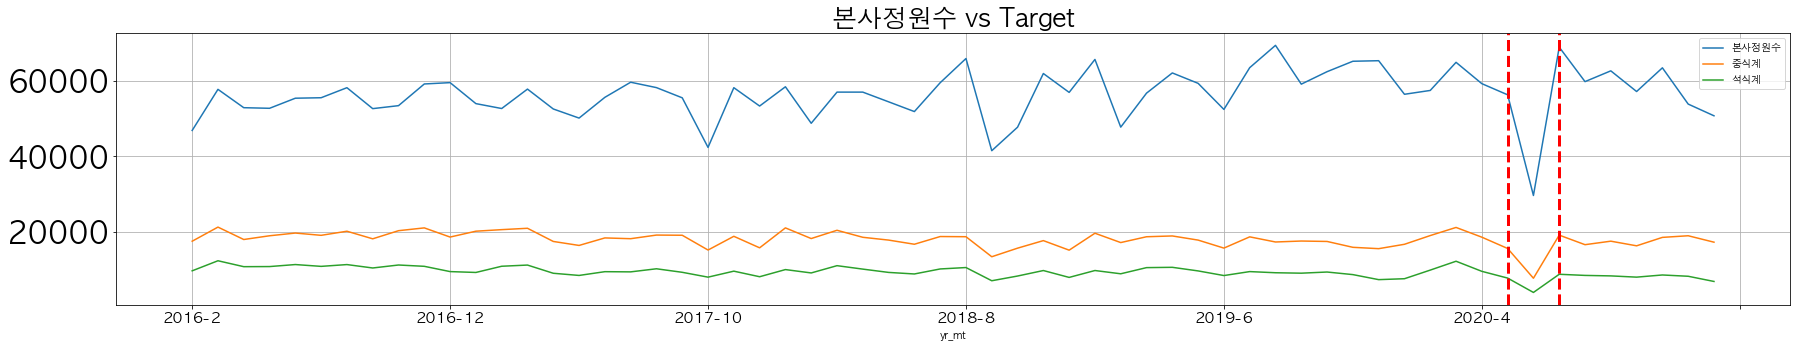

In [39]:
#본사정원수에 따른 중석식계의 영향은?
mt_wk_emp = train.groupby(['year','month'])['본사정원수','중식계','석식계'].agg('sum').reset_index()
mt_wk_emp['yr_mt'] = mt_wk_emp['year'].astype(str)+ '-' + mt_wk_emp['month'].astype(str)
mt_wk_emp.plot(x = 'yr_mt', y = ['본사정원수', '중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.axvline(x=51, color='r', linestyle='--', linewidth=3)
plt.axvline(x=53, color='r', linestyle='--', linewidth=3)
plt.title('본사정원수 vs Target', fontsize = 25)
plt.show()

## 시각화결과
    *본사 정원수가 줄어들었기에 중석식계도 감소한 것으로 확인된다.
    의문 : LH는 공기업인데 본사 정원수가 감소한다는 것을 무슨 의미일까?
        은퇴,이직,지사로 이동..?
        감축 방안은 △상위 관리직 및 지원부서 감축(226명) △기능이관 및 폐지(519명) △기능축소(330명) 등이다
        (http://www.gnnews.co.kr/news/articleView.html?idxno=476594)
        >그렇다면 이것을 변수로 생성할 수 있을까?

In [11]:
#직원의 증감을 나타내는 변수 만들기
train['emp_var'] = 0
test['emp_var'] = 0
for df in [train,test]:
    for i in range(0,len(df)-1):
        df['emp_var'][i] = df.본사정원수[i+1] - df.본사정원수[i]

In [13]:
train.head(50)
test.head(5)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,year,month,week,day,내부근무자수,요일(석식),emp_var
0,2021-01-27,3,2983,88,182,5,358.0,2021,1,4,27,2355.0,5,0
1,2021-01-28,4,2983,104,212,409,348.0,2021,1,4,28,2319.0,3,0
2,2021-01-29,5,2983,270,249,0,294.0,2021,1,4,29,2170.0,4,-59
3,2021-02-01,1,2924,108,154,538,322.0,2021,2,5,1,2340.0,1,0
4,2021-02-02,2,2924,62,186,455,314.0,2021,2,5,2,2362.0,2,0


emp_var의 value가 0이면 직원수의 변동이 없고 있으면 신입이 들어온 날  
또한, emp_var>0이면 직원이 증가하고 <0이면 직원이 감소한날.  
* 아이디어: 추후 factor변수로 추가 파생변수 가능할듯?  
ex)직원 수 증가가 있던 달 변수 1/0, 직원 수 감소가 있던 달 변수 1/0  
### 현재 상태로는 크게 의미있는 변수가 아니라서 이후에 변형이 필요함.

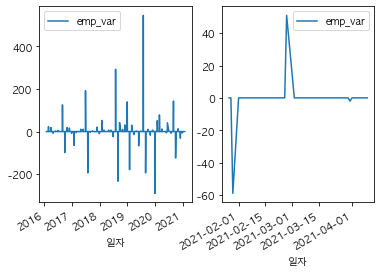

<Figure size 1080x432 with 0 Axes>

In [42]:
fig, ax = plt.subplots(1,2)
plt.figure(figsize=(15, 6)) 
train.plot(x = '일자',y = 'emp_var',ax = ax[0])
test.plot(x = '일자', y = 'emp_var',ax= ax[1])
plt.show()

# 토픽모델링 적용

In [14]:
train_tp = pd.read_csv('train_topic.csv',encoding = 'cp949')
test_tp = pd.read_csv('test_topic.csv',encoding = 'cp949')

In [15]:
train_tp = train_tp[['Topic1','Topic2','Topic3','Topic4','일자','clust']]
test_tp = test_tp[['Topic1','Topic2','Topic3','Topic4','일자','clust']]

In [16]:
train_tp['일자'] = pd.to_datetime(train_tp['일자'])
test_tp['일자'] = pd.to_datetime(test_tp['일자'])

In [17]:
train =pd.merge(train,train_tp, left_on='일자', right_on='일자', how='left')
test = pd.merge(test,test_tp,left_on = '일자', right_on='일자', how ='left')

In [18]:
#Topic 변수 na값은 0으로 대체
train = train.fillna(0)
test = test.fillna(0)

In [232]:
#Clust 변수 factor화
#train['clust'] = train['clust'].astype(str)
#test['clust'] = test['clust'].astype(str)

#>Facotr화하면 모델에 적용이 안됌. why?

In [233]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   year            1205 non-null   int64         
 10  month           1205 non-null   int64         
 11  week            1205 non-null   int64         
 12  day             1205 non-null   int64         
 13  내부근무자수          1205 non-null   float64       
 14  요일(석식)          1205 non-null   int64         
 15  emp_

In [19]:
#변수들의 실제 비율을 알고자 변수 생성
train['휴가비율'] = train.본사휴가자수 / train.본사정원수
train['출장비율'] = train.본사출장자수 / train.본사정원수
train['야근비율'] = train.본사시간외근무명령서승인건수 / train.본사정원수
train['재택근무비율'] = train.현본사소속재택근무자수 / train.본사정원수

test['휴가비율'] = test.본사휴가자수 / test.본사정원수
test['출장비율'] = test.본사출장자수 / test.본사정원수
test['야근비율'] = test.본사시간외근무명령서승인건수 / test.본사정원수
test['재택근무비율'] = test.현본사소속재택근무자수 / test.본사정원수

In [235]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   year            1205 non-null   int64         
 10  month           1205 non-null   int64         
 11  week            1205 non-null   int64         
 12  day             1205 non-null   int64         
 13  내부근무자수          1205 non-null   float64       
 14  요일(석식)          1205 non-null   int64         
 15  emp_

In [12]:
#일자,yr_mt drop
#train.drop(['일자'],axis = 1,inplace = True)
#test.drop(['일자'],axis = 1,inplace = True)
#Data select에서 선택안하면 됌.

# 요일별 평균  
요일별 평균 중석식계 구해서 df에 매핑하기

In [20]:
dow_mean = train.groupby(['요일'])['중식계','석식계'].agg('mean').reset_index().round()
dow_mean.rename(columns = {'중식계':'중식계요일평균',
                '석식계':'석식계요일평균'},inplace = True)
train = pd.merge(train,dow_mean, left_on='요일', right_on='요일', how='left')
test = pd.merge(test,dow_mean,left_on = '요일', right_on='요일', how ='left')

In [146]:
train.head(5)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,year,month,week,day,내부근무자수,요일(석식),emp_var,Topic1,Topic2,Topic3,Topic4,clust,휴가비율,출장비율,야근비율,재택근무비율,중식계요일평균,석식계요일평균
0,2016-02-01,1,2601,50,150,238,0.0,1039.0,331.0,2016,2,5,1,2401.0,1,0,0.275250,0.477257,0.208932,0.038561,1.0,0.019223,0.057670,0.091503,0.0,1144.0,539.0
1,2016-02-02,2,2601,50,173,319,0.0,867.0,560.0,2016,2,5,2,2378.0,2,0,0.083321,0.756997,0.107424,0.052259,1.0,0.019223,0.066513,0.122645,0.0,926.0,520.0
2,2016-02-03,3,2601,56,180,111,0.0,1017.0,573.0,2016,2,5,3,2365.0,5,0,0.054342,0.334866,0.029374,0.581418,1.0,0.021530,0.069204,0.042676,0.0,905.0,364.0
3,2016-02-04,4,2601,104,220,355,0.0,978.0,525.0,2016,2,5,4,2277.0,3,0,0.131070,0.580402,0.250128,0.038400,1.0,0.039985,0.084583,0.136486,0.0,824.0,480.0
4,2016-02-05,5,2601,278,181,34,0.0,925.0,330.0,2016,2,5,5,2142.0,4,0,0.448661,0.454137,0.048543,0.048659,1.0,0.106882,0.069589,0.013072,0.0,654.0,405.0


# Modeling

In [237]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   year            1205 non-null   int64         
 10  month           1205 non-null   int64         
 11  week            1205 non-null   int64         
 12  day             1205 non-null   int64         
 13  내부근무자수          1205 non-null   float64       
 14  요일(석식)          1205 non-null   int64         
 15  emp_

In [78]:
train_lunch = train[['요일','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균','Topic1','Topic2','Topic3','Topic4','clust']]
lunch_y = train['중식계']
test_lunch = test[['요일','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균','Topic1','Topic2','Topic3','Topic4','clust']]

train_dinner = train[['요일(석식)','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균','Topic1','Topic2','Topic3','Topic4','clust']]
dinner_y = train['석식계']
test_dinner = test[['요일(석식)','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균','Topic1','Topic2','Topic3','Topic4','clust']]

In [21]:
#X_train = train[['요일','요일(석식)','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균','Topic1','Topic2','Topic3','Topic4','clust']]
#y1_train = train['중식계']
#y2_train = train['석식계']

#X_test = test[['요일','요일(석식)','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균','Topic1','Topic2','Topic3','Topic4','clust']]


In [79]:
from sklearn.ensemble import RandomForestRegressor
rf_lunch = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_dinner = RandomForestRegressor(n_jobs=-1, random_state=42)
#feature1 = X_test.columns.values

In [80]:
rf_lunch.fit(train_lunch, lunch_y)
rf_dinner.fit(train_dinner,dinner_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [81]:
pred_lunch = rf_lunch.predict(test_lunch)
pred_dinner = rf_dinner.predict(test_dinner)

# Importance plot

In [49]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [50]:
rf_model1.feature_importances_

array([0.23129204, 0.02148369, 0.04780762, 0.08047966, 0.02477275,
       0.00400087, 0.03054564, 0.07088413, 0.00378242, 0.08966509,
       0.01992864, 0.03404462, 0.01164232, 0.01069793, 0.00147596,
       0.22264979, 0.09484683])

# 중식계 importance plot

In [82]:
importances = rf_lunch.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

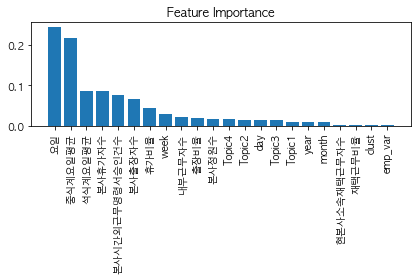

In [83]:
plt.title('Feature Importance')
plt.bar(range(train_lunch.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(train_lunch.shape[1]), train_lunch.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# 석식계 imporatance plot

In [84]:
importances = rf_dinner.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

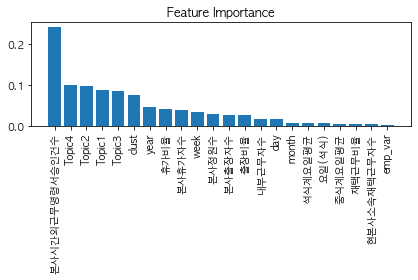

In [85]:
plt.title('Feature Importance')
plt.bar(range(train_dinner.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(train_dinner.shape[1]), train_dinner.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [246]:
submission = pd.read_csv('sample_submission.csv',encoding = 'utf-8')

In [247]:
submission['중식계'] = pred1
submission['석식계'] = pred2

In [249]:
submission.to_csv('Topic02.csv', index=False)
#87

# Catboost

In [256]:
train_x = X_train
train_y = train['중식계']

In [262]:
cat_models={}

def cat_kfold(max_depth, learning_rate, random_seed):
    
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    
    for seed in random_seed:
        for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
            print(f'===================================={n_fold+1}============================================')
            
            X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
            y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

            # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
            cat = CatBoostRegressor(n_estimators=3000, max_depth=max_depth, random_seed=seed, learning_rate=learning_rate, bootstrap_type ='Bernoulli')
            cat.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=50,verbose=100)

            cat_models[n_fold] = cat

            # val 데이터 예측
            predictions = cat.predict(X_val)
            # test 데이터 예측
            test_predictions = cat.predict(test)

            # val 데이터 예측 logloss 값 저장
            #logloss=log_loss(to_categorical(y_val), predictions)
            mae = mean_absolute_error(y_val, predictions)
            outcomes.append(mae)
            print(f"FOLD {n_fold+1} : mae:{mae}")

            # test 데이터 예측 결과 종합
            # 최종 적으로는 kolds 횟수 만큼 나눠서 평균 값을 활용
            sub+=test_predictions

            print(f'================================================================================\n\n')

    # 저장된 val 데이터 예측 logloss 값의 평균 값으로 성능을 비교
    mean_outcome=np.mean(outcomes)
    print("Mean:{}".format(mean_outcome))
    
    return sub/(folds.n_splits * len(random_seed))

In [266]:
cat_kfold(8, 0.04, [1042])

====================================1============================================
0:	learn: 201.9069714	test: 201.9069714	test1: 214.6451397	best: 214.6451397 (0)	total: 14.6ms	remaining: 43.9s
100:	learn: 77.6271947	test: 77.6271947	test1: 104.3915987	best: 104.3915987 (100)	total: 614ms	remaining: 17.6s
200:	learn: 60.3482994	test: 60.3482994	test1: 98.3880304	best: 98.3880304 (200)	total: 1.17s	remaining: 16.3s
300:	learn: 48.4810543	test: 48.4810543	test1: 96.9747174	best: 96.9397050 (274)	total: 2.01s	remaining: 18.1s
400:	learn: 39.0160067	test: 39.0160067	test1: 96.3580131	best: 96.2729824 (388)	total: 2.46s	remaining: 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 96.27298241
bestIteration = 388

Shrink model to first 389 iterations.
FOLD 1 : mae:70.61850363630629


ValueError: operands could not be broadcast together with shapes (50,3) (50,) (50,3) 

# XGBoost

In [26]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

params = {
    'learning_rate': [0.0, 0.1, 0.09, 0.089, 0.08],
    'boosting_type': ['gbtree', 'gblinear', 'dart'],
    
}

lunch_r = XGBRegressor(objective='reg:squarederror')
dinner_r = XGBRegressor(objective='reg:squarederror')

lunch_model = GridSearchCV(lunch_r, params, scoring='neg_mean_absolute_error')
dinner_model = GridSearchCV(dinner_r, params, scoring='neg_mean_absolute_error')

In [27]:
X_train = train[['요일','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균']]
y1_train = train['중식계']
y2_train = train['석식계']

X_test = test[['요일','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균']]


lunch_model.fit(X_train,y1_train)
print(lunch_model.best_score_, lunch_model.best_params_)
lunch_model = lunch_model.best_estimator_

[00:48:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

[00:48:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

[00:48:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

[00:48:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

In [35]:
X_test
y1_pred = lunch_model.predict(X_test)

In [34]:
dinner_model.fit(X_train, y2_train)
print(dinner_model.best_score_, dinner_model.best_params_)
dinner_model = dinner_model.best_estimator_

[00:51:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:51:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:51:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

[00:51:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:51:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:51:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

[00:51:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:51:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:51:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

[00:51:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:51:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:51:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

In [36]:
X_test
y2_pred = dinner_model.predict(X_test)

In [42]:
submission['중식계'] = y1_pred.round()
submission['석식계'] = y2_pred.round()

In [44]:
submission.to_csv('gm_xgb.csv', index=False)
#성능 안좋아짐.

NameError: name 'train' is not defined

# Pycaret
train/test 분리 잘못해서 오류뜸. 내일 다시 제출

In [60]:
train_lunch = train[['요일','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균','Topic1','Topic2','Topic3','Topic4','clust','중식계']]
test_lunch = test[['요일','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균','Topic1','Topic2','Topic3','Topic4','clust']]

train_dinner = train[['요일(석식)','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균','Topic1','Topic2','Topic3','Topic4','clust','석식계']]
test_dinner = test[['요일(석식)','본사정원수','휴가비율','본사시간외근무명령서승인건수','출장비율','재택근무비율', '내부근무자수','본사출장자수','현본사소속재택근무자수', '본사휴가자수','day', 'week', 'month', 'year','emp_var','중식계요일평균','석식계요일평균','Topic1','Topic2','Topic3','Topic4','clust']]

In [61]:
#중식 모델
reg = setup(data=train_lunch,
            target='중식계',
            numeric_imputation = 'mean',
            normalize = True,
            fold =5,
            silent= True)

,Description,Value
0,session_id,876
1,Target,중식계
2,Original Data,"(1205, 23)"
3,Missing Values,False
4,Numeric Features,19
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 41)"


In [62]:
best_model = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,67.3574,8149.6502,90.1854,0.8103,0.1138,0.0830,1.3180
huber,Huber Regressor,70.2900,8991.4624,94.7156,0.7921,0.1155,0.0841,0.0440
lr,Linear Regression,71.2377,9006.9499,94.8090,0.7918,0.1160,0.0859,0.0160
ridge,Ridge Regression,71.6015,9012.0292,94.8248,0.7917,0.1167,0.0865,0.0200
gbr,Gradient Boosting Regressor,70.8462,9016.6026,94.8763,0.7907,0.1188,0.0867,0.1220
br,Bayesian Ridge,71.9333,9068.6905,95.1075,0.7904,0.1178,0.0873,0.0120
lasso,Lasso Regression,72.4222,9274.7497,96.1880,0.7854,0.1191,0.0880,0.0140
lightgbm,Light Gradient Boosting Machine,73.3339,9363.3617,96.6688,0.7826,0.1206,0.0896,0.6080
rf,Random Forest Regressor,72.9533,9532.1415,97.5558,0.7791,0.1218,0.0896,0.2880
et,Extra Trees Regressor,73.9389,9604.0310,97.8408,0.7769,0.1222,0.0906,0.2100


In [64]:
blended_l = blend_models(estimator_list = best_model, fold = 10, optimize = 'MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)
pred_esb_l = predict_model(final_model_l, test_lunch)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,63.7652,6045.1960,77.7509,0.8557,0.0967,0.0793
1,69.5721,8469.6203,92.0305,0.8436,0.1182,0.0914
2,67.2045,8223.6220,90.6842,0.7830,0.1078,0.0806
3,73.3733,9492.9362,97.4317,0.7961,0.1267,0.0931
4,62.0409,6081.2983,77.9827,0.8484,0.0938,0.0708
5,74.0399,10465.5703,102.3014,0.7900,0.1351,0.0916
6,67.8332,9612.6583,98.0442,0.6919,0.1089,0.0761
7,58.8946,5549.8346,74.4972,0.8814,0.0987,0.0720
8,63.7192,7514.6169,86.6869,0.8346,0.1046,0.0759
9,67.7711,8734.1364,93.4566,0.7787,0.1025,0.0762


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,66.2865,7970.5561,89.2780,0.8189,0.1100,0.0798


0)catboost만 압도적으로 성능이 좋음 : 67.35(이전 seed에서는 66까지 나옴), 나머지는 70초반이므로 catboost 단일모델만 제출 필요
1)n = 3, blend_model fold=5 : 70.8876
2)n = 3, blend_model fold = 10: 66.8

In [ ]:
pred_esb_l = predict_model(final_model_l, test_lunch)

In [65]:
pred_esb_l['Label']

0      974.191832
1      896.277341
2      622.056193
3     1324.741465
4     1062.158357
5     1016.714649
6      992.692294
7      745.169101
8     1327.836948
9     1083.965600
10     852.641607
11    1354.242353
12    1161.682370
13    1070.305811
14     948.362338
15     719.301171
16    1285.612714
17    1088.466370
18     952.918230
19     910.724132
20     647.618121
21    1087.684380
22    1001.015932
23     957.612964
24     703.785745
25    1323.011681
26    1159.705884
27    1002.753073
28     939.770509
29     704.052291
30    1325.068225
31    1072.216372
32     997.436696
33     912.099812
34     660.643547
35    1258.560592
36    1027.722507
37     902.585543
38     826.563634
39     605.509727
40    1238.640966
41    1024.118583
42     942.237606
43     813.697632
44     603.240470
45    1229.755293
46    1043.723807
47     924.497711
48     869.267870
49     608.631420
Name: Label, dtype: float64

In [66]:
#석식계
reg = setup(data=train_dinner,
            target='석식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

,Description,Value
0,session_id,7545
1,Target,석식계
2,Original Data,"(1205, 23)"
3,Missing Values,False
4,Numeric Features,19
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 40)"


In [71]:
best_model2 = compare_models(n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,47.2707,4257.8350,64.7474,0.7827,0.7636,0.1091,0.0100
br,Bayesian Ridge,47.3293,4266.3102,64.8103,0.7823,0.7712,0.1093,0.0120
huber,Huber Regressor,46.9549,4276.3786,64.9185,0.7817,0.7314,0.1096,0.0310
catboost,CatBoost Regressor,46.7571,4414.8881,65.5610,0.7740,0.7094,0.1097,1.1540
lightgbm,Light Gradient Boosting Machine,47.5235,4418.3673,65.6058,0.7720,0.5788,0.1143,0.3550
gbr,Gradient Boosting Regressor,47.0470,4535.4989,66.4952,0.7691,0.6614,0.1105,0.0970
lasso,Lasso Regression,49.1346,4525.4505,66.7346,0.7688,0.7819,0.1148,0.0150
rf,Random Forest Regressor,48.7847,4695.0133,67.7845,0.7601,0.4458,0.1181,0.2890
xgboost,Extreme Gradient Boosting,48.9415,4781.4337,68.3900,0.7555,0.5979,0.1175,0.5090
par,Passive Aggressive Regressor,50.8422,4999.3392,69.9719,0.7446,0.7485,0.1196,0.0110


In [73]:
blended_d = blend_models(estimator_list = best_model2, fold = 10, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, test_dinner)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,47.9698,4016.1448,63.3731,0.7684,0.4368,0.1013
1,38.0770,2460.9144,49.6076,0.8509,0.6192,0.0803
2,49.2275,5886.4310,76.7231,0.6774,0.8079,0.1034
3,45.6891,3206.0947,56.6224,0.8374,0.5332,0.1146
4,37.1084,2393.1700,48.9200,0.8889,0.7118,0.0859
5,46.8869,3500.5781,59.1657,0.8230,0.8598,0.1031
6,46.8503,3992.5011,63.1862,0.8481,0.8404,0.1289
7,42.3959,4380.3097,66.1839,0.7794,0.5849,0.0918
8,43.6984,3076.5454,55.4666,0.8605,0.7921,0.1014
9,47.7432,5998.0686,77.4472,0.6709,0.8187,0.1393


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,45.9099,4294.3657,65.5314,0.7509,0.5157,0.1171


0)catboost 46.75로 중식처럼 다른 모델보다 압도적으로 성능 좋은 편은 아니나 가장 성능이 좋은 모델임, 나머지 47~
1)n = 3, fold = 10 : 48.55
2)n = 3, fold = 5 : 47.55
3)n = 5, fold = 5 :45.90
4)n = 5, fold = 10: 45.90

In [74]:
pred_esb_d = predict_model(final_model_d, test_dinner)

In [75]:
pred_esb_d['Label']

0     360.762152
1     394.045390
2     265.169625
3     536.106342
4     463.229827
5     405.688155
6     456.637488
7     356.182651
8     589.895798
9     510.197749
10    286.326929
11    646.898158
12    616.898244
13    419.615969
14    499.411158
15    355.583134
16    616.438845
17    591.044019
18    393.805118
19    484.079749
20    311.777501
21    620.368919
22    431.661286
23    555.646130
24    379.484483
25    665.146774
26    664.112853
27    421.551570
28    514.780477
29    332.679549
30    666.427598
31    553.145255
32    420.436576
33    477.204093
34    324.073146
35    602.259685
36    566.197122
37    396.279319
38    447.010449
39    306.116361
40    576.476470
41    543.657302
42    405.281690
43    409.999466
44    292.801800
45    574.309610
46    542.544588
47    387.695255
48    446.626567
49    290.026937
Name: Label, dtype: float64

In [87]:
submission = pd.read_csv('sample_submission.csv',encoding = 'utf-8')

In [88]:
submission['중식계'] = pred_esb_l['Label']
submission['석식계'] = pred_esb_d['Label']

In [89]:
submission.to_csv('pycaret03.csv', index=False)

# Autoviml

In [ ]:
from autoviml.Auto_ViML import Auto_ViML

In [255]:
target = '중식계'
m, feats, trainm, testm = Auto_ViML(train_lunch, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',
                            feature_reduction=True,
                             Boosting_Flag=True, Binning_Flag=False,
                            Add_Poly=False, Stacking_Flag=True,Imbalanced_Flag=False,
                            verbose=2)

##############  D A T A   S E T  A N A L Y S I S  #######################
Training Set Shape = (1205, 13)
    Training Set Memory Usage = 0.12 MB
Test Set Shape = (50, 15)
    Test Set Memory Usage = 0.01 MB
Single_Label Target: ['중식계']
No shuffling of data set before training...
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
Data Set Shape: 1205 rows, 12 cols
Data Set columns info:
* 요일: 0 nulls, 5 unique vals, most common: {4: 244, 1: 241}
* 휴가비율: 0 nulls, 1100 unique vals, most common: {0.026365348399246705: 3, 0.025423728813559324: 3}
* 출장비율: 0 nulls, 1113 unique vals, most common: {0.10621669626998224: 3, 0.09874723655121592: 3}
* 재택근무비율: 0 nulls, 193 unique vals, most common: {0.0: 988, 0.006779661016949152: 3}
* 내부근무자수: 0 nulls, 522 unique vals, most common: {2334.0: 9, 2330.0: 8}
* 본사출장자수: 0 nulls, 194 unique vals, m

TypeError: cannot unpack non-iterable NoneType object